In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_auc_score, average_precision_score,
                           precision_recall_curve, roc_curve, f1_score)

# Advanced ML models
import xgboost as xgb
import lightgbm as lgb

# Imbalanced learning
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from collections import Counter

#Utilities
import ipaddress
from datetime import datetime
import joblib
import pickle
from google.colab import drive, files

In [50]:
# Define data paths (adjust these paths according to your Google Drive structure)
FRAUD_DATA_PATH = '/content/drive/MyDrive/fraud_detection/Fraud_Data.csv'
IP_COUNTRY_PATH = '/content/drive/MyDrive/fraud_detection/IpAddress_to_Country.csv'
CREDITCARD_PATH = '/content/drive/MyDrive/fraud_detection/creditcard.csv'

def load_datasets():
    """Load all datasets from Google Drive with error handling"""
    datasets = {}

    try:
        # Load Fraud Data
        print("Loading Fraud_Data.csv...")
        fraud_data = pd.read_csv(FRAUD_DATA_PATH)
        datasets['fraud_data'] = fraud_data
        print(f"Loaded: {fraud_data.shape[0]} rows, {fraud_data.shape[1]} columns")

        # Load IP to Country mapping
        print("Loading IpAddress_to_Country.csv...")
        ip_country = pd.read_csv(IP_COUNTRY_PATH)
        datasets['ip_country'] = ip_country
        print(f"Loaded: {ip_country.shape[0]} IP ranges")

        # Load Credit Card Data
        print("Loading creditcard.csv...")
        creditcard_data = pd.read_csv(CREDITCARD_PATH)
        datasets['creditcard_data'] = creditcard_data
        print(f"Loaded: {creditcard_data.shape[0]} rows, {creditcard_data.shape[1]} columns")

        return datasets

    except Exception as e:
        print(f"Error loading data: {e}")
        print("Please ensure the data files are in the correct Google Drive paths.")
        return None

In [51]:
# Load datasets
datasets = load_datasets()

if datasets:
    fraud_data = datasets['fraud_data']
    ip_country = datasets['ip_country']
    creditcard_data = datasets['creditcard_data']
    print("\nAll datasets loaded successfully!")
else:
    print("Please check your file paths and try again.")

Loading Fraud_Data.csv...
Loaded: 151112 rows, 11 columns
Loading IpAddress_to_Country.csv...
Loaded: 138846 IP ranges
Loading creditcard.csv...
Loaded: 284807 rows, 31 columns

All datasets loaded successfully!


### EXPLORATORY DATA ANALYSIS (EDA)

In [52]:
class FraudDataAnalyzer:
    """Comprehensive fraud data analysis class"""

    def __init__(self, fraud_df, creditcard_df):
        self.fraud_df = fraud_df.copy()
        self.creditcard_df = creditcard_df.copy()

In [53]:
def add_method(cls):
    def decorator(func):
        setattr(cls, func.__name__, func)
        return func
    return decorator

In [54]:
@add_method(FraudDataAnalyzer)
def basic_info_analysis(self):
    print("=" * 80)
    print("DATASET OVERVIEW")
    print("=" * 80)

    # Fraud Data Analysis
    print("\nFRAUD DATA (E-COMMERCE) ANALYSIS:")
    print(f"Shape: {self.fraud_df.shape}")
    print(f"Memory usage: {self.fraud_df.memory_usage().sum() / 1024**2:.2f} MB")

    print("\nColumn Information:")
    print(self.fraud_df.info())

    print("\nMissing Values:")
    missing_fraud = self.fraud_df.isnull().sum()
    print(missing_fraud[missing_fraud > 0])

    # Credit Card Data Analysis
    print("\nCREDIT CARD DATA ANALYSIS:")
    print(f"Shape: {self.creditcard_df.shape}")
    print(f"Memory usage: {self.creditcard_df.memory_usage().sum() / 1024**2:.2f} MB")

    print("\nMissing Values:")
    missing_cc = self.creditcard_df.isnull().sum()
    print(missing_cc[missing_cc > 0])

In [55]:
@add_method(FraudDataAnalyzer)
def class_imbalance_analysis(self):
    print("=" * 80)
    print("CLASS IMBALANCE ANALYSIS")
    print("=" * 80)

    # Fraud Data
    fraud_class_dist = self.fraud_df['class'].value_counts()
    fraud_imbalance_ratio = fraud_class_dist[0] / fraud_class_dist[1]
    fraud_rate = (fraud_class_dist[1] / len(self.fraud_df)) * 100

    print("\nFRAUD DATA (E-COMMERCE):")
    print(f"Legitimate transactions: {fraud_class_dist[0]:,}")
    print(f"Fraudulent transactions: {fraud_class_dist[1]:,}")
    print(f"Imbalance ratio: {fraud_imbalance_ratio:.2f}:1")
    print(f"Fraud rate: {fraud_rate:.4f}%")

    # Credit Card Data
    cc_class_dist = self.creditcard_df['Class'].value_counts()
    cc_imbalance_ratio = cc_class_dist[0] / cc_class_dist[1]
    cc_fraud_rate = (cc_class_dist[1] / len(self.creditcard_df)) * 100

    print("\nCREDIT CARD DATA:")
    print(f"Legitimate transactions: {cc_class_dist[0]:,}")
    print(f"Fraudulent transactions: {cc_class_dist[1]:,}")
    print(f"Imbalance ratio: {cc_imbalance_ratio:.2f}:1")
    print(f"Fraud rate: {cc_fraud_rate:.4f}%")

    # Visualization
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=['E-commerce Fraud Distribution', 'Credit Card Fraud Distribution'],
        specs=[[{"type": "pie"}, {"type": "pie"}]]
    )

    fig.add_trace(go.Pie(labels=['Legitimate', 'Fraudulent'],
                         values=[fraud_class_dist[0], fraud_class_dist[1]],
                         marker_colors=['lightblue', 'red'],
                         textinfo='label+percent+value'),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=['Legitimate', 'Fraudulent'],
                         values=[cc_class_dist[0], cc_class_dist[1]],
                         marker_colors=['lightgreen', 'orange'],
                         textinfo='label+percent+value'),
                  row=1, col=2)

    fig.update_layout(height=400, title_text="Class Distribution Comparison")
    fig.show()

    return {
        'fraud_data': {'imbalance_ratio': fraud_imbalance_ratio, 'fraud_rate': fraud_rate},
        'creditcard_data': {'imbalance_ratio': cc_imbalance_ratio, 'fraud_rate': cc_fraud_rate}
    }

In [56]:
@add_method(FraudDataAnalyzer)
def feature_analysis(self):
    print("=" * 80)
    print("FEATURE ANALYSIS")
    print("=" * 80)

    # Fraud Data
    print("\nFRAUD DATA FEATURES:")

    numerical_cols = self.fraud_df.select_dtypes(include=[np.number]).columns.tolist()
    if 'class' in numerical_cols:
        numerical_cols.remove('class')

    print(f"Numerical features: {numerical_cols}")
    print("\nNumerical Features Statistics:")
    print(self.fraud_df[numerical_cols].describe())

    categorical_cols = self.fraud_df.select_dtypes(include=['object']).columns.tolist()
    print(f"\nCategorical features: {categorical_cols}")

    for col in categorical_cols:
        if col not in ['user_id', 'device_id', 'ip_address']:
            print(f"\n{col.upper()} Distribution:")
            print(self.fraud_df[col].value_counts().head())

    # Credit Card Data
    print("\nCREDIT CARD FEATURES:")
    print("Features V1-V28 are PCA-transformed (anonymized)")
    print("Time and Amount are original features")

    print("\nCredit Card Statistics:")
    print(self.creditcard_df[['Time', 'Amount']].describe())

In [57]:
@add_method(FraudDataAnalyzer)
def fraud_pattern_analysis(self):
    print("=" * 80)
    print("FRAUD PATTERN ANALYSIS")
    print("=" * 80)

    # E-commerce
    print("\nE-COMMERCE FRAUD PATTERNS:")

    fraud_amounts = self.fraud_df[self.fraud_df['class'] == 1]['purchase_value']
    legit_amounts = self.fraud_df[self.fraud_df['class'] == 0]['purchase_value']

    print(f"Average fraud amount: ${fraud_amounts.mean():.2f}")
    print(f"Average legitimate amount: ${legit_amounts.mean():.2f}")
    print(f"Median fraud amount: ${fraud_amounts.median():.2f}")
    print(f"Median legitimate amount: ${legit_amounts.median():.2f}")

    fraud_age = self.fraud_df[self.fraud_df['class'] == 1]['age'].mean()
    legit_age = self.fraud_df[self.fraud_df['class'] == 0]['age'].mean()
    print(f"\nAge patterns: Fraud={fraud_age:.1f}, Legitimate={legit_age:.1f}")

    print("\nGender fraud patterns:")
    print(self.fraud_df.groupby('sex')['class'].agg(['count', 'sum', 'mean']).round(4))

    print("\nBrowser fraud patterns:")
    print(self.fraud_df.groupby('browser')['class'].agg(['count', 'sum', 'mean']).round(4).head())

    # Credit Card
    print("\nCREDIT CARD FRAUD PATTERNS:")

    cc_fraud_amounts = self.creditcard_df[self.creditcard_df['Class'] == 1]['Amount']
    cc_legit_amounts = self.creditcard_df[self.creditcard_df['Class'] == 0]['Amount']

    print(f"Average fraud amount: ${cc_fraud_amounts.mean():.2f}")
    print(f"Average legitimate amount: ${cc_legit_amounts.mean():.2f}")
    print(f"Median fraud amount: ${cc_fraud_amounts.median():.2f}")
    print(f"Median legitimate amount: ${cc_legit_amounts.median():.2f}")

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0,0].hist(legit_amounts, bins=50, alpha=0.7, label='Legitimate', color='blue')
    axes[0,0].hist(fraud_amounts, bins=50, alpha=0.7, label='Fraud', color='red')
    axes[0,0].set_title('E-commerce Transaction Amounts')
    axes[0,0].set_yscale('log')
    axes[0,0].legend()

    axes[0,1].hist(np.log1p(legit_amounts), bins=50, alpha=0.7, label='Legitimate', color='blue')
    axes[0,1].hist(np.log1p(fraud_amounts), bins=50, alpha=0.7, label='Fraud', color='red')
    axes[0,1].set_title('E-commerce Log Transaction Amounts')
    axes[0,1].legend()

    axes[1,0].hist(cc_legit_amounts, bins=50, alpha=0.7, label='Legitimate', color='green')
    axes[1,0].hist(cc_fraud_amounts, bins=50, alpha=0.7, label='Fraud', color='orange')
    axes[1,0].set_title('Credit Card Transaction Amounts')
    axes[1,0].set_yscale('log')
    axes[1,0].legend()

    axes[1,1].hist(np.log1p(cc_legit_amounts), bins=50, alpha=0.7, label='Legitimate', color='green')
    axes[1,1].hist(np.log1p(cc_fraud_amounts), bins=50, alpha=0.7, label='Fraud', color='orange')
    axes[1,1].set_title('Credit Card Log Transaction Amounts')
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()

DATASET OVERVIEW

FRAUD DATA (E-COMMERCE) ANALYSIS:
Shape: (151112, 11)
Memory usage: 12.68 MB

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB
None

Missing Values:
Series([], dtype: int64)

CREDIT CARD DATA ANALYSIS:
Shape: (284807, 31)
Memory usage: 67.

FEATURE ANALYSIS

FRAUD DATA FEATURES:
Numerical features: ['user_id', 'purchase_value', 'age', 'ip_address']

Numerical Features Statistics:
             user_id  purchase_value            age    ip_address
count  151112.000000   151112.000000  151112.000000  1.511120e+05
mean   200171.040970       36.935372      33.140704  2.152145e+09
std    115369.285024       18.322762       8.617733  1.248497e+09
min         2.000000        9.000000      18.000000  5.209350e+04
25%    100642.500000       22.000000      27.000000  1.085934e+09
50%    199958.000000       35.000000      33.000000  2.154770e+09
75%    300054.000000       49.000000      39.000000  3.243258e+09
max    400000.000000      154.000000      76.000000  4.294850e+09

Categorical features: ['signup_time', 'purchase_time', 'device_id', 'source', 'browser', 'sex']

SIGNUP_TIME Distribution:
signup_time
2015-06-10 07:02:20    1
2015-02-24 22:55:49    1
2015-06-07 20:39:50    1
2015-01-01 18:52:44    1
2015-04-28 21:13:25    1
Nam

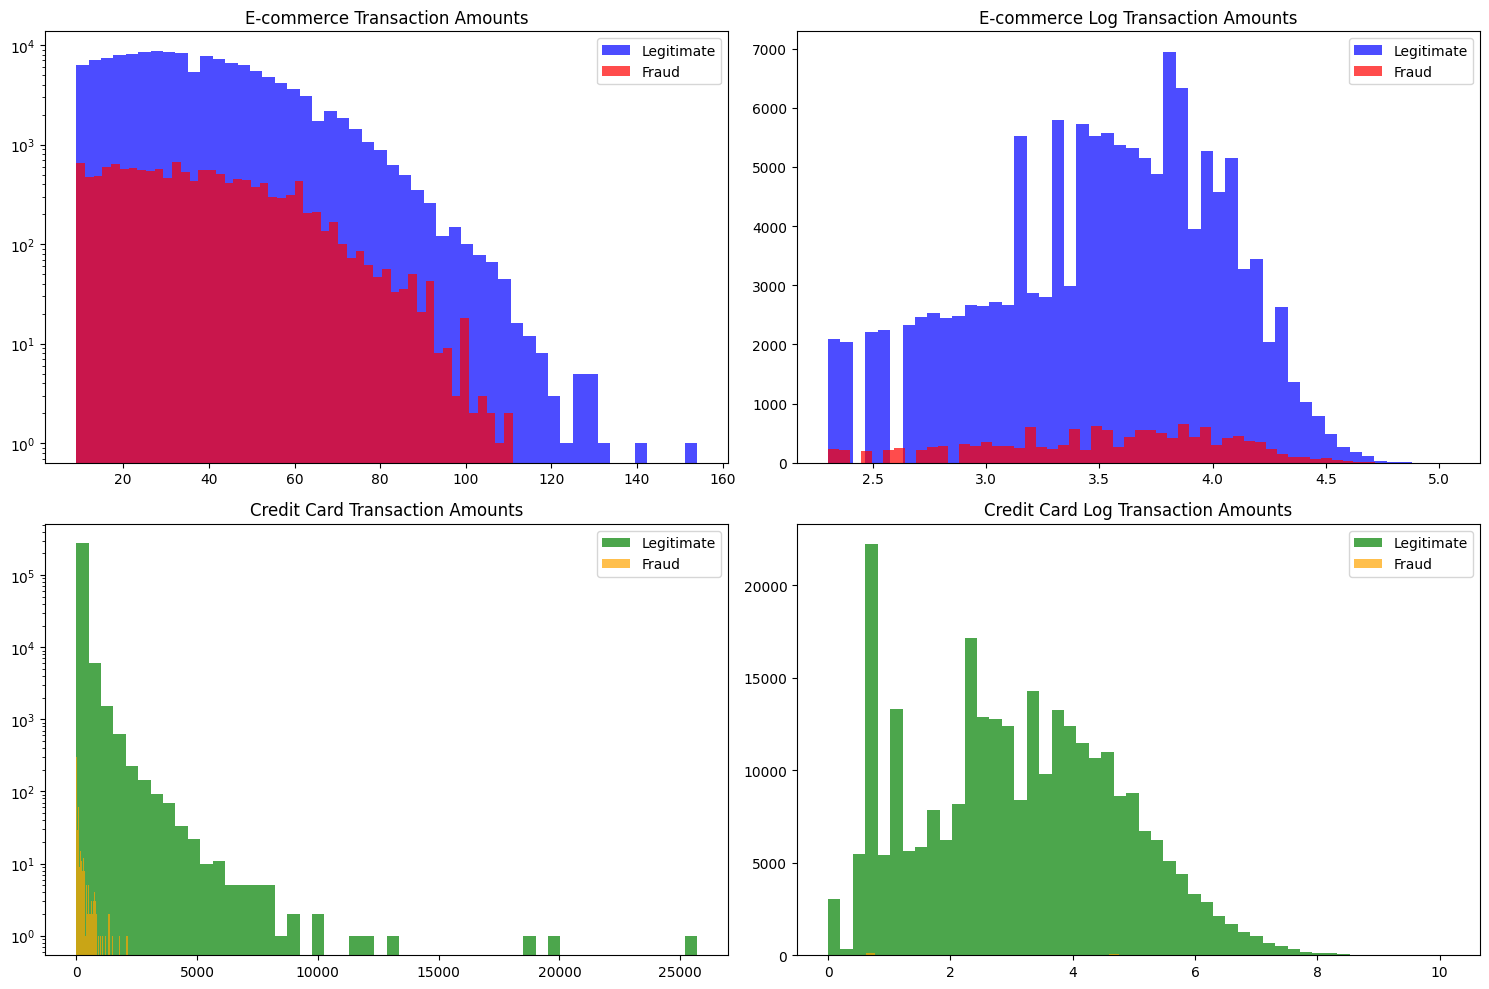

In [58]:
# Initialize analyzer
analyzer = FraudDataAnalyzer(fraud_data, creditcard_data)

# Run comprehensive analysis
analyzer.basic_info_analysis()
imbalance_info = analyzer.class_imbalance_analysis()
analyzer.feature_analysis()
analyzer.fraud_pattern_analysis()

### Data Preprocessing and Cleaning

In [59]:
class FraudDataPreprocessor:
    """Advanced data preprocessing for fraud detection"""

    def __init__(self):
        self.fraud_encoders = {}
        self.fraud_scalers = {}
        self.cc_scalers = {}

In [60]:
@add_method(FraudDataPreprocessor)
def clean_fraud_data(self, df):
    """Clean and preprocess fraud data"""
    print("Cleaning Fraud Data...")
    df_clean = df.copy()

    # Handle missing values
    print(f"Missing values before cleaning: {df_clean.isnull().sum().sum()}")

    # Remove duplicates
    duplicates = df_clean.duplicated().sum()
    if duplicates > 0:
        df_clean = df_clean.drop_duplicates()
        print(f"Removed {duplicates} duplicate rows")

    # Data type corrections
    df_clean['signup_time'] = pd.to_datetime(df_clean['signup_time'])
    df_clean['purchase_time'] = pd.to_datetime(df_clean['purchase_time'])

    # Remove rows with invalid data
    initial_rows = len(df_clean)

    # Remove negative purchase values
    df_clean = df_clean[df_clean['purchase_value'] > 0]

    # Remove invalid ages
    df_clean = df_clean[(df_clean['age'] >= 18) & (df_clean['age'] <= 100)]

    # Remove future timestamps
    current_time = datetime.now()
    df_clean = df_clean[df_clean['purchase_time'] <= current_time]
    df_clean = df_clean[df_clean['signup_time'] <= current_time]

    print(f"Removed {initial_rows - len(df_clean)} invalid rows")
    print(f"Final dataset shape: {df_clean.shape}")

    return df_clean

In [61]:
@add_method(FraudDataPreprocessor)
def clean_creditcard_data(self, df):
    """Clean and preprocess credit card data"""
    print("Cleaning Credit Card Data...")
    df_clean = df.copy()

    # Handle missing values
    print(f"Missing values before cleaning: {df_clean.isnull().sum().sum()}")

    # Remove duplicates
    duplicates = df_clean.duplicated().sum()
    if duplicates > 0:
        df_clean = df_clean.drop_duplicates()
        print(f"Removed {duplicates} duplicate rows")

    # Remove negative amounts
    initial_rows = len(df_clean)
    df_clean = df_clean[df_clean['Amount'] >= 0]

    print(f"Removed {initial_rows - len(df_clean)} invalid rows")
    print(f"Final dataset shape: {df_clean.shape}")

    return df_clean

In [62]:
@add_method(FraudDataPreprocessor)
def ip_to_country_mapping(self, ip_df, ip_address):
    """Convert IP address to country using the mapping dataset"""
    try:
        ip_int = int(ipaddress.IPv4Address(ip_address))

        # Find matching range
        country_row = ip_df[
            (ip_df['lower_bound_ip_address'] <= ip_int) &
            (ip_df['upper_bound_ip_address'] >= ip_int)
        ]

        return country_row['country'].iloc[0] if not country_row.empty else 'Unknown'
    except:
        return 'Unknown'

In [63]:
@add_method(FraudDataPreprocessor)
def advanced_feature_engineering(self, fraud_df, ip_country_df):
    """Create advanced features for fraud detection"""
    print("Advanced Feature Engineering...")
    df_featured = fraud_df.copy()

    # 1. Temporal Features
    print("Creating temporal features...")
    df_featured['signup_time'] = pd.to_datetime(df_featured['signup_time'])
    df_featured['purchase_time'] = pd.to_datetime(df_featured['purchase_time'])

    # Time differences
    df_featured['time_since_signup'] = (
        df_featured['purchase_time'] - df_featured['signup_time']
    ).dt.total_seconds() / 3600  # in hours

    # Time-based features
    df_featured['purchase_hour'] = df_featured['purchase_time'].dt.hour
    df_featured['purchase_day_of_week'] = df_featured['purchase_time'].dt.dayofweek
    df_featured['purchase_month'] = df_featured['purchase_time'].dt.month
    df_featured['signup_hour'] = df_featured['signup_time'].dt.hour
    df_featured['signup_day_of_week'] = df_featured['signup_time'].dt.dayofweek

    # Behavioral flags
    df_featured['immediate_purchase'] = (df_featured['time_since_signup'] < 1).astype(int)
    df_featured['same_day_purchase'] = (df_featured['time_since_signup'] < 24).astype(int)
    df_featured['weekend_purchase'] = df_featured['purchase_day_of_week'].isin([5, 6]).astype(int)
    df_featured['night_purchase'] = (
        (df_featured['purchase_hour'] >= 22) | (df_featured['purchase_hour'] <= 6)
    ).astype(int)

    # 2. Geolocation Features
    print("Creating geolocation features...")
    # Map IP addresses to countries (this might take a while)
    print("Mapping IP addresses to countries...")
    df_featured['country'] = df_featured['ip_address'].apply(
        lambda ip: self.ip_to_country_mapping(ip_country_df, ip)
    )

    # Country-based risk features
    country_fraud_rates = df_featured.groupby('country')['class'].mean()
    df_featured['country_fraud_rate'] = df_featured['country'].map(country_fraud_rates)
    df_featured['high_risk_country'] = (
        df_featured['country_fraud_rate'] > country_fraud_rates.quantile(0.8)
    ).astype(int)

    # 3. User Behavior Features
    print("Creating user behavior features...")
    user_stats = df_featured.groupby('user_id').agg({
        'purchase_value': ['count', 'sum', 'mean', 'std'],
        'device_id': 'nunique',
        'ip_address': 'nunique',
        'country': 'nunique',
        'browser': 'nunique',
        'source': 'nunique'
    })

    # Flatten column names
    user_stats.columns = ['_'.join(col).strip() for col in user_stats.columns]
    user_stats.reset_index(inplace=True)

    # Merge back
    df_featured = df_featured.merge(user_stats, on='user_id', how='left')

    # User risk indicators
    df_featured['multiple_devices'] = (df_featured['device_id_nunique'] > 1).astype(int)
    df_featured['multiple_ips'] = (df_featured['ip_address_nunique'] > 1).astype(int)
    df_featured['multiple_countries'] = (df_featured['country_nunique'] > 1).astype(int)
    df_featured['multiple_browsers'] = (df_featured['browser_nunique'] > 1).astype(int)
    df_featured['multiple_sources'] = (df_featured['source_nunique'] > 1).astype(int)

    # 4. Device and Browser Intelligence
    print("Creating device/browser features...")
    # Browser fraud rates
    browser_fraud_rates = df_featured.groupby('browser')['class'].mean()
    df_featured['browser_fraud_rate'] = df_featured['browser'].map(browser_fraud_rates)

    # Source fraud rates
    source_fraud_rates = df_featured.groupby('source')['class'].mean()
    df_featured['source_fraud_rate'] = df_featured['source'].map(source_fraud_rates)

    # Device sharing analysis
    device_stats = df_featured.groupby('device_id').agg({
        'user_id': 'nunique',
        'class': 'mean'
    }).reset_index()
    device_stats.columns = ['device_id', 'users_per_device', 'device_fraud_rate']
    df_featured = df_featured.merge(device_stats, on='device_id', how='left')

    # 5. Transaction Amount Features
    print("Creating transaction amount features...")
    # Amount percentiles and z-scores
    df_featured['amount_percentile'] = df_featured['purchase_value'].rank(pct=True)
    df_featured['amount_zscore'] = (
        df_featured['purchase_value'] - df_featured['purchase_value'].mean()
    ) / df_featured['purchase_value'].std()

    # Amount flags
    df_featured['high_amount'] = (
        df_featured['purchase_value'] > df_featured['purchase_value'].quantile(0.95)
    ).astype(int)
    df_featured['low_amount'] = (
        df_featured['purchase_value'] < df_featured['purchase_value'].quantile(0.05)
    ).astype(int)
    df_featured['round_amount'] = (df_featured['purchase_value'] % 1 == 0).astype(int)

    # 6. Age and Gender Features
    print("Creating demographic features...")
    # Age groups
    df_featured['age_group'] = pd.cut(
        df_featured['age'],
        bins=[0, 25, 35, 50, 65, 100],
        labels=['18-25', '26-35', '36-50', '51-65', '65+']
    )

    # Gender-age interaction
    df_featured['gender_age_group'] = df_featured['sex'] + '_' + df_featured['age_group'].astype(str)

    print(f"Feature engineering completed. New shape: {df_featured.shape}")
    return df_featured

In [64]:
@add_method(FraudDataPreprocessor)
def encode_categorical_features(self, df, fit=True):
    """Encode categorical features"""
    print("Encoding categorical features...")
    df_encoded = df.copy()

    # Categorical columns to encode
    categorical_cols = ['browser', 'source', 'sex', 'country', 'age_group', 'gender_age_group']

    for col in categorical_cols:
        if col in df_encoded.columns:
            if fit:
                le = LabelEncoder()
                df_encoded[f'{col}_encoded'] = le.fit_transform(df_encoded[col].astype(str))
                self.fraud_encoders[col] = le
            else:
                if col in self.fraud_encoders:
                    # Handle unknown categories
                    le = self.fraud_encoders[col]
                    df_encoded[f'{col}_temp'] = df_encoded[col].astype(str)
                    mask = df_encoded[f'{col}_temp'].isin(le.classes_)
                    df_encoded[f'{col}_encoded'] = 0  # default value
                    df_encoded.loc[mask, f'{col}_encoded'] = le.transform(df_encoded.loc[mask, f'{col}_temp'])
                    df_encoded.drop(f'{col}_temp', axis=1, inplace=True)
                else:
                    df_encoded[f'{col}_encoded'] = 0

    return df_encoded

In [65]:
@add_method(FraudDataPreprocessor)
def scale_features(self, df, target_col='class', fit=True, dataset_type='fraud'):
    """Scale numerical features"""
    print(f"Scaling {dataset_type} features...")
    df_scaled = df.copy()

    # Select numerical columns (excluding target and ID columns)
    exclude_cols = [target_col, 'user_id', 'device_id', 'ip_address', 'signup_time', 'purchase_time']
    if dataset_type == 'creditcard':
        exclude_cols = [target_col]

    numerical_cols = df_scaled.select_dtypes(include=[np.number]).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col not in exclude_cols]

    if fit:
        scaler = StandardScaler()
        df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])
        if dataset_type == 'fraud':
            self.fraud_scalers['standard'] = scaler
        else:
            self.cc_scalers['standard'] = scaler
    else:
        if dataset_type == 'fraud' and 'standard' in self.fraud_scalers:
            scaler = self.fraud_scalers['standard']
            df_scaled[numerical_cols] = scaler.transform(df_scaled[numerical_cols])
        elif dataset_type == 'creditcard' and 'standard' in self.cc_scalers:
            scaler = self.cc_scalers['standard']
            df_scaled[numerical_cols] = scaler.transform(df_scaled[numerical_cols])

    return df_scaled, numerical_cols

In [66]:
# Initialize preprocessor
preprocessor = FraudDataPreprocessor()

# Clean datasets
print("=" * 80)
print("DATA PREPROCESSING")
print("=" * 80)

fraud_data_clean = preprocessor.clean_fraud_data(fraud_data)
creditcard_data_clean = preprocessor.clean_creditcard_data(creditcard_data)

# Feature engineering for fraud data
fraud_data_featured = preprocessor.advanced_feature_engineering(fraud_data_clean, ip_country)

# Encode categorical features
fraud_data_encoded = preprocessor.encode_categorical_features(fraud_data_featured, fit=True)

print(f"\n Preprocessing completed!")
print(f"Fraud data final shape: {fraud_data_encoded.shape}")
print(f"Credit card data final shape: {creditcard_data_clean.shape}")


DATA PREPROCESSING
Cleaning Fraud Data...
Missing values before cleaning: 0
Removed 0 invalid rows
Final dataset shape: (151112, 11)
Cleaning Credit Card Data...
Missing values before cleaning: 0
Removed 1081 duplicate rows
Removed 0 invalid rows
Final dataset shape: (283726, 31)
Advanced Feature Engineering...
Creating temporal features...
Creating geolocation features...
Mapping IP addresses to countries...
Creating user behavior features...
Creating device/browser features...
Creating transaction amount features...
Creating demographic features...
Feature engineering completed. New shape: (151112, 49)
Encoding categorical features...

 Preprocessing completed!
Fraud data final shape: (151112, 55)
Credit card data final shape: (283726, 31)


### Class Imbalance Handling

In [67]:
class ImbalanceHandler:
    """Advanced class imbalance handling techniques"""

    def __init__(self):
        self.samplers = {
            'smote': SMOTE(random_state=42, k_neighbors=3),
            'adasyn': ADASYN(random_state=42),
            'borderline_smote': BorderlineSMOTE(random_state=42, kind='borderline-1'),
            'smote_tomek': SMOTETomek(random_state=42)
        }

    def analyze_imbalance(self, y, dataset_name):
        """Comprehensive imbalance analysis"""
        print(f"\n{dataset_name.upper()} IMBALANCE ANALYSIS:")
        counter = Counter(y)
        majority_class = max(counter, key=counter.get)
        minority_class = min(counter, key=counter.get)

        imbalance_ratio = counter[majority_class] / counter[minority_class]
        minority_percentage = (counter[minority_class] / sum(counter.values())) * 100

        print(f"Class Distribution: {counter}")
        print(f"Imbalance Ratio: {imbalance_ratio:.2f}:1")
        print(f"Minority Class Percentage: {minority_percentage:.4f}%")

        # Recommend strategies based on imbalance severity
        if imbalance_ratio > 100:
            print("SEVERE IMBALANCE: Recommend ensemble methods + advanced resampling")
            recommended_techniques = ['smote', 'adasyn', 'smote_tomek']
        elif imbalance_ratio > 10:
            print("MODERATE IMBALANCE: Recommend SMOTE + cost-sensitive learning")
            recommended_techniques = ['smote', 'borderline_smote']
        else:
            print("MILD IMBALANCE: Class weights may be sufficient")
            recommended_techniques = ['class_weights']

        return {
            'imbalance_ratio': imbalance_ratio,
            'minority_percentage': minority_percentage,
            'recommended_techniques': recommended_techniques,
            'counter': counter
        }

    def apply_resampling(self, X, y, method='smote'):
        """Apply selected resampling method"""
        print(f"Applying {method.upper()} resampling...")

        original_counter = Counter(y)
        print(f"Original distribution: {original_counter}")

        if method in self.samplers:
            try:
                sampler = self.samplers[method]
                X_resampled, y_resampled = sampler.fit_resample(X, y)

                resampled_counter = Counter(y_resampled)
                print(f"Resampled distribution: {resampled_counter}")
                print(f"Samples added: {len(y_resampled) - len(y)} ({(len(y_resampled) - len(y))/len(y)*100:.1f}% increase)")

                return X_resampled, y_resampled

            except Exception as e:
                print(f"Error applying {method}: {e}")
                print("Returning original data...")
                return X, y
        else:
            print(f"Unknown resampling method: {method}")
            return X, y

    def compare_resampling_methods(self, X, y, methods=None):
        """Compare different resampling methods"""
        if methods is None:
            methods = list(self.samplers.keys())

        results = {}
        original_size = len(y)
        original_counter = Counter(y)

        print(f"\nCOMPARING RESAMPLING METHODS:")
        print(f"Original size: {original_size}")
        print(f"Original distribution: {original_counter}")

        for method in methods:
            print(f"\n--- {method.upper()} ---")
            try:
                X_res, y_res = self.apply_resampling(X, y, method)
                results[method] = {
                    'original_size': original_size,
                    'resampled_size': len(y_res),
                    'size_increase': len(y_res) - original_size,
                    'size_increase_pct': ((len(y_res) - original_size) / original_size) * 100,
                    'final_distribution': Counter(y_res),
                    'balance_ratio': Counter(y_res)[0] / Counter(y_res)[1]
                }
            except Exception as e:
                results[method] = {'error': str(e)}

        return results

    def calculate_class_weights(self, y):
        """Calculate optimal class weights for cost-sensitive learning"""
        from sklearn.utils.class_weight import compute_class_weight

        classes = np.unique(y)
        weights = compute_class_weight('balanced', classes=classes, y=y)
        class_weight_dict = dict(zip(classes, weights))

        print(f"Calculated class weights: {class_weight_dict}")
        return class_weight_dict

In [68]:
# Initialize imbalance handler
imbalance_handler = ImbalanceHandler()

# Analyze imbalance in both datasets
print("=" * 80)
print("CLASS IMBALANCE HANDLING")
print("=" * 80)

# Prepare features for imbalance analysis
# Fraud data features
fraud_feature_cols = [col for col in fraud_data_encoded.columns
                     if col not in ['user_id', 'device_id', 'ip_address', 'signup_time',
                                   'purchase_time', 'class', 'browser', 'source', 'sex',
                                   'country', 'age_group', 'gender_age_group']]

X_fraud = fraud_data_encoded[fraud_feature_cols]
y_fraud = fraud_data_encoded['class']

# Credit card features
X_creditcard = creditcard_data_clean.drop('Class', axis=1)
y_creditcard = creditcard_data_clean['Class']

# Analyze imbalance
fraud_imbalance_info = imbalance_handler.analyze_imbalance(y_fraud, "E-commerce Fraud")
cc_imbalance_info = imbalance_handler.analyze_imbalance(y_creditcard, "Credit Card")

# Calculate class weights for both datasets
fraud_class_weights = imbalance_handler.calculate_class_weights(y_fraud)
cc_class_weights = imbalance_handler.calculate_class_weights(y_creditcard)

# Check for NaNs in the feature engineered data before splitting
print("\nChecking for NaNs in feature engineered data...")
print(f"NaNs in fraud_data_encoded: {fraud_data_encoded.isnull().sum().sum()}")
print(f"NaNs in creditcard_data_clean: {creditcard_data_clean.isnull().sum().sum()}")

# Handle NaNs after feature engineering and before scaling
# For simplicity, we'll fill NaNs with the mean of numerical columns. More sophisticated imputation can be used.
print("\nHandling NaNs by filling with mean of numerical columns...")
fraud_data_encoded[fraud_data_encoded.select_dtypes(include=np.number).columns] = fraud_data_encoded.select_dtypes(include=np.number).fillna(fraud_data_encoded.select_dtypes(include=np.number).mean())
creditcard_data_clean[creditcard_data_clean.select_dtypes(include=np.number).columns] = creditcard_data_clean.select_dtypes(include=np.number).fillna(creditcard_data_clean.select_dtypes(include=np.number).mean())


print(f"NaNs after filling for fraud_data_encoded: {fraud_data_encoded.isnull().sum().sum()}")
print(f"NaNs after filling for creditcard_data_clean: {creditcard_data_clean.isnull().sum().sum()}")

CLASS IMBALANCE HANDLING

E-COMMERCE FRAUD IMBALANCE ANALYSIS:
Class Distribution: Counter({0: 136961, 1: 14151})
Imbalance Ratio: 9.68:1
Minority Class Percentage: 9.3646%
MILD IMBALANCE: Class weights may be sufficient

CREDIT CARD IMBALANCE ANALYSIS:
Class Distribution: Counter({0: 283253, 1: 473})
Imbalance Ratio: 598.84:1
Minority Class Percentage: 0.1667%
SEVERE IMBALANCE: Recommend ensemble methods + advanced resampling
Calculated class weights: {np.int64(0): np.float64(0.5516606917297625), np.int64(1): np.float64(5.339269309589429)}
Calculated class weights: {np.int64(0): np.float64(0.5008349426131409), np.int64(1): np.float64(299.9217758985201)}

Checking for NaNs in feature engineered data...
NaNs in fraud_data_encoded: 151112
NaNs in creditcard_data_clean: 0

Handling NaNs by filling with mean of numerical columns...
NaNs after filling for fraud_data_encoded: 151112
NaNs after filling for creditcard_data_clean: 0


### Train-Test Split and Data Preparation

In [69]:
print("\n" + "=" * 80)
print("TRAIN-TEST SPLIT AND DATA PREPARATION")
print("=" * 80)

# Scale features before splitting
fraud_data_scaled, fraud_numerical_cols = preprocessor.scale_features(
    fraud_data_encoded, target_col='class', fit=True, dataset_type='fraud'
)

cc_data_scaled, cc_numerical_cols = preprocessor.scale_features(
    creditcard_data_clean, target_col='Class', fit=True, dataset_type='creditcard'
)

# Prepare final feature sets
X_fraud_final = fraud_data_scaled[fraud_feature_cols]
y_fraud_final = fraud_data_scaled['class']

X_cc_final = cc_data_scaled.drop('Class', axis=1)
y_cc_final = cc_data_scaled['Class']

print("Final feature dimensions:")
print(f"E-commerce fraud: {X_fraud_final.shape}")
print(f"Credit card: {X_cc_final.shape}")

# Stratified train-test split
print("\nPerforming stratified train-test split...")

# Fraud data split
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(
    X_fraud_final, y_fraud_final,
    test_size=0.2,
    random_state=42,
    stratify=y_fraud_final
)

# Credit card split
X_cc_train, X_cc_test, y_cc_train, y_cc_test = train_test_split(
    X_cc_final, y_cc_final,
    test_size=0.2,
    random_state=42,
    stratify=y_cc_final
)

print("Train-test split completed:")
print(f"E-commerce - Train: {X_fraud_train.shape}, Test: {X_fraud_test.shape}")
print(f"Credit card - Train: {X_cc_train.shape}, Test: {X_cc_test.shape}")

# Verify class distribution is maintained
print("\nClass distribution verification:")
print(f"E-commerce train: {Counter(y_fraud_train)}")
print(f"E-commerce test: {Counter(y_fraud_test)}")
print(f"Credit card train: {Counter(y_cc_train)}")
print(f"Credit card test: {Counter(y_cc_test)}")

# Apply resampling to training data only
print("\nApplying SMOTE resampling to training data...")

# Apply SMOTE to fraud training data
X_fraud_train_balanced, y_fraud_train_balanced = imbalance_handler.apply_resampling(
    X_fraud_train, y_fraud_train, method='smote'
)

# Apply SMOTE to credit card training data
X_cc_train_balanced, y_cc_train_balanced = imbalance_handler.apply_resampling(
    X_cc_train, y_cc_train, method='smote'
)

print("Resampling completed!")


TRAIN-TEST SPLIT AND DATA PREPARATION
Scaling fraud features...
Scaling creditcard features...
Final feature dimensions:
E-commerce fraud: (151112, 43)
Credit card: (283726, 30)

Performing stratified train-test split...
Train-test split completed:
E-commerce - Train: (120889, 43), Test: (30223, 43)
Credit card - Train: (226980, 30), Test: (56746, 30)

Class distribution verification:
E-commerce train: Counter({0: 109568, 1: 11321})
E-commerce test: Counter({0: 27393, 1: 2830})
Credit card train: Counter({0: 226602, 1: 378})
Credit card test: Counter({0: 56651, 1: 95})

Applying SMOTE resampling to training data...
Applying SMOTE resampling...
Original distribution: Counter({0: 109568, 1: 11321})
Error applying smote: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it i

### Model Training and Evaluation

In [70]:
class FraudModelTrainer:
    """Advanced fraud detection model training and evaluation"""

    def __init__(self):
        self.models = {}
        self.results = {}

    def create_models(self, class_weights=None):
        """Create baseline and ensemble models"""
        models = {}

        # 1. Logistic Regression (Baseline)
        models['logistic_regression'] = LogisticRegression(
            random_state=42,
            class_weight=class_weights,
            max_iter=1000,
            solver='liblinear'
        )

        # 2. Random Forest
        models['random_forest'] = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            class_weight=class_weights,
            n_jobs=-1
        )

        # 3. XGBoost
        if class_weights:
            scale_pos_weight = class_weights[1] / class_weights[0]
        else:
            scale_pos_weight = 1

        models['xgboost'] = xgb.XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            eval_metric='aucpr',
            use_label_encoder=False
        )

        # 4. LightGBM
        models['lightgbm'] = lgb.LGBMClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            class_weight=class_weights,
            random_state=42,
            verbose=-1
        )

        return models

    def train_models(self, X_train, y_train, dataset_name, class_weights=None):
        """Train all models on given dataset"""
        print(f"\nTraining models on {dataset_name} dataset...")

        models = self.create_models(class_weights)
        trained_models = {}

        for name, model in models.items():
            print(f"Training {name}...")
            try:
                model.fit(X_train, y_train)
                trained_models[name] = model
                print(f"{name} trained successfully")
            except Exception as e:
                print(f"Error training {name}: {e}")

        self.models[dataset_name] = trained_models
        return trained_models

    def calculate_fraud_metrics(self, y_true, y_pred, y_pred_proba):
        """Calculate comprehensive fraud detection metrics"""
        from sklearn.metrics import (precision_score, recall_score, f1_score,
                                    accuracy_score, matthews_corrcoef)

        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1_score': f1_score(y_true, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_true, y_pred_proba),
            'pr_auc': average_precision_score(y_true, y_pred_proba),
            'mcc': matthews_corrcoef(y_true, y_pred)
        }

        return metrics

    def evaluate_models(self, X_test, y_test, dataset_name):
        """Evaluate all trained models"""
        print(f"\nEvaluating models on {dataset_name} dataset...")

        if dataset_name not in self.models:
            print(f"No trained models found for {dataset_name}")
            return None

        results = {}
        trained_models = self.models[dataset_name]

        for name, model in trained_models.items():
            print(f"Evaluating {name}...")

            try:
                # Predictions
                y_pred = model.predict(X_test)
                y_pred_proba = model.predict_proba(X_test)[:, 1]

                # Calculate metrics
                metrics = self.calculate_fraud_metrics(y_test, y_pred, y_pred_proba)

                # Confusion matrix
                cm = confusion_matrix(y_test, y_pred)

                results[name] = {
                    'metrics': metrics,
                    'confusion_matrix': cm,
                    'y_pred': y_pred,
                    'y_pred_proba': y_pred_proba
                }

                print(f"{name} evaluated - F1: {metrics['f1_score']:.4f}, AUC-PR: {metrics['pr_auc']:.4f}")

            except Exception as e:
                print(f"Error evaluating {name}: {e}")

        self.results[dataset_name] = results
        return results

    def print_results_summary(self, dataset_name):
        """Print comprehensive results summary"""
        if dataset_name not in self.results:
            print(f"No results found for {dataset_name}")
            return

        results = self.results[dataset_name]
        print(f"\n{dataset_name.upper()} RESULTS SUMMARY:")
        print("=" * 80)

        # Create results DataFrame
        metrics_df = pd.DataFrame({
            model_name: result['metrics']
            for model_name, result in results.items()
        }).T

        # Sort by F1 score
        metrics_df = metrics_df.sort_values('f1_score', ascending=False)

        print(metrics_df.round(4))

        # Identify best model
        best_model = metrics_df.index[0]
        print(f"\nBest performing model: {best_model}")
        print(f"F1-Score: {metrics_df.loc[best_model, 'f1_score']:.4f}")
        print(f"Precision: {metrics_df.loc[best_model, 'precision']:.4f}")
        print(f"Recall: {metrics_df.loc[best_model, 'recall']:.4f}")
        print(f"AUC-PR: {metrics_df.loc[best_model, 'pr_auc']:.4f}")

        return best_model, metrics_df

    def plot_confusion_matrices(self, dataset_name):
        """Plot confusion matrices for all models"""
        if dataset_name not in self.results:
            return

        results = self.results[dataset_name]
        n_models = len(results)

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.ravel()

        for idx, (name, result) in enumerate(results.items()):
            if idx < len(axes):
                cm = result['confusion_matrix']
                sns.heatmap(
                    cm,
                    annot=True,
                    fmt='d',
                    ax=axes[idx],
                    cmap='Blues',
                    cbar=False
                )
                axes[idx].set_title(f'{name} - Confusion Matrix')
                axes[idx].set_xlabel('Predicted')
                axes[idx].set_ylabel('Actual')

        # Hide unused subplots
        for idx in range(len(results), len(axes)):
            axes[idx].set_visible(False)

        plt.suptitle(f'{dataset_name.upper()} - Confusion Matrices')
        plt.tight_layout()
        plt.show()

    def plot_roc_pr_curves(self, X_test, y_test, dataset_name):
        """Plot ROC and Precision-Recall curves"""
        if dataset_name not in self.results:
            return

        results = self.results[dataset_name]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # ROC Curves
        for name, result in results.items():
            y_pred_proba = result['y_pred_proba']

            # ROC curve
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = result['metrics']['roc_auc']
            ax1.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

            # PR curve
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
            pr_auc = result['metrics']['pr_auc']
            ax2.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.3f})')

        # ROC plot formatting
        ax1.plot([0, 1], [0, 1], 'k--', label='Random')
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title(f'{dataset_name.upper()} - ROC Curves')
        ax1.legend()
        ax1.grid(True)

        # PR plot formatting
        baseline_precision = Counter(y_test)[1] / len(y_test)
        ax2.axhline(y=baseline_precision, color='k', linestyle='--', label=f'Baseline ({baseline_precision:.3f})')
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_title(f'{dataset_name.upper()} - Precision-Recall Curves')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()


Handling NaNs in resampled fraud training data...
NaNs in X_fraud_train_balanced after filling: 120889

Training models on fraud_data dataset...
Training logistic_regression...
Error training logistic_regression: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
Training random_forest...
random_forest trained successfully
Training xgboost...
xgboost trained successfully
Training lightgbm...
lightgbm train

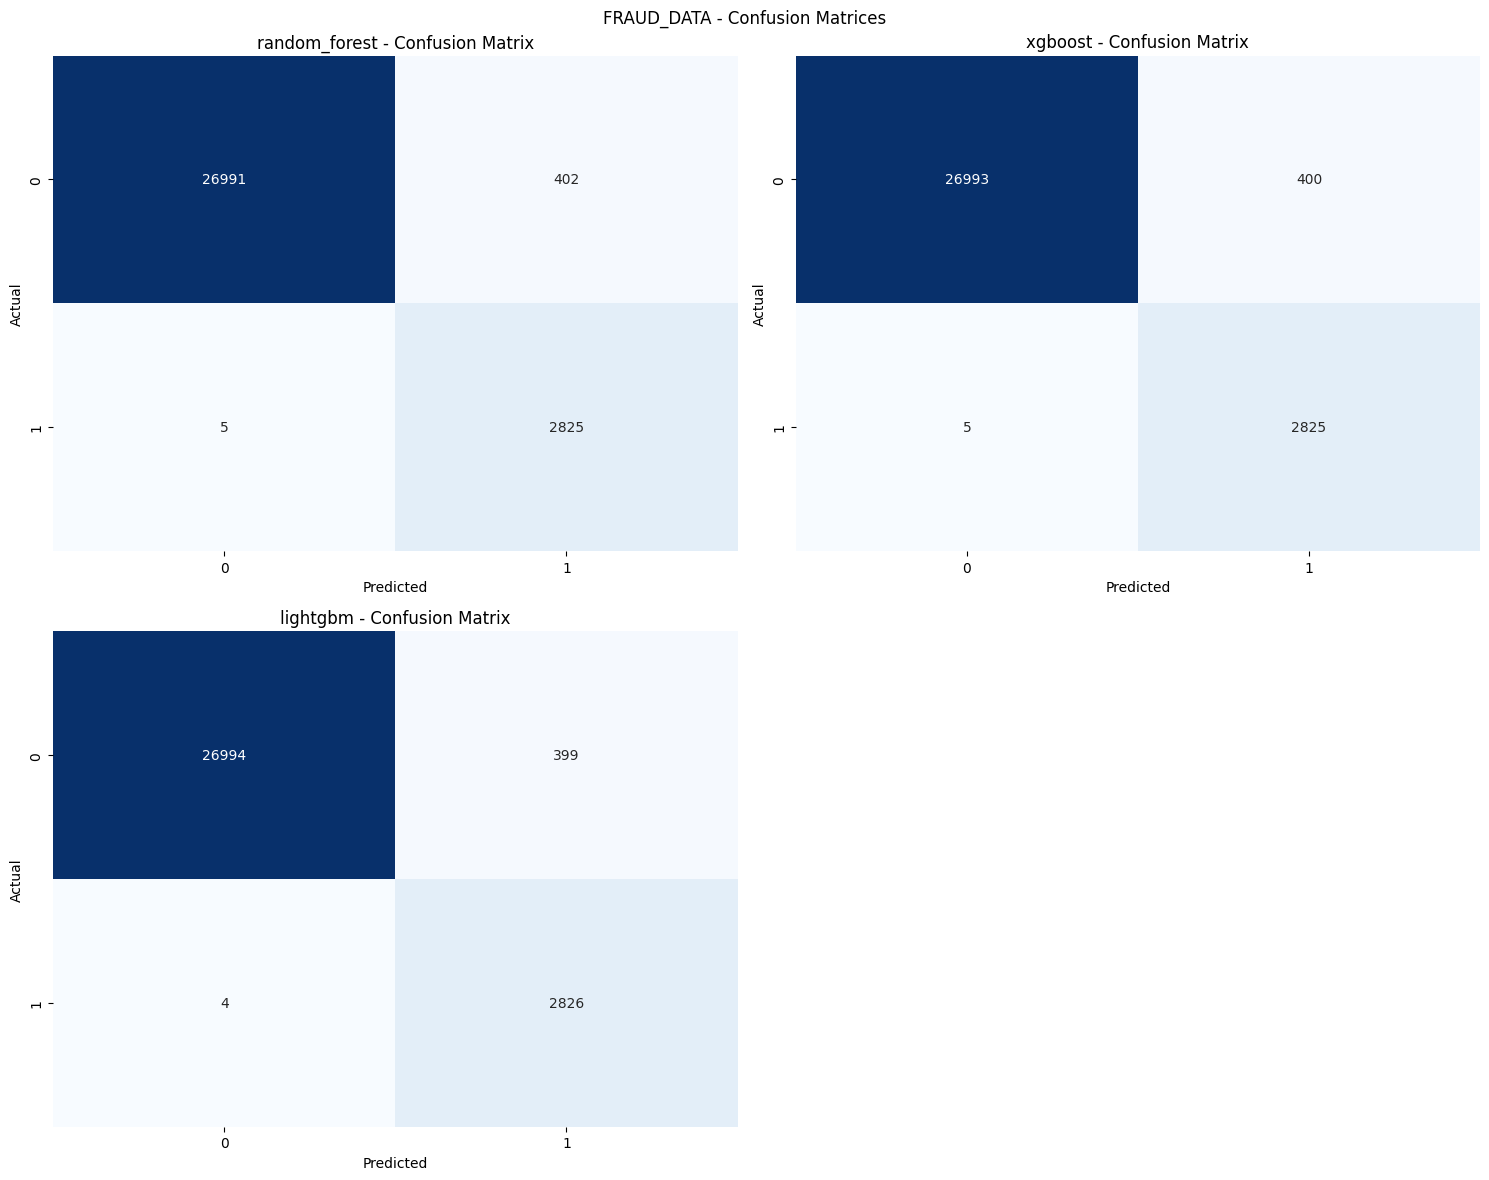

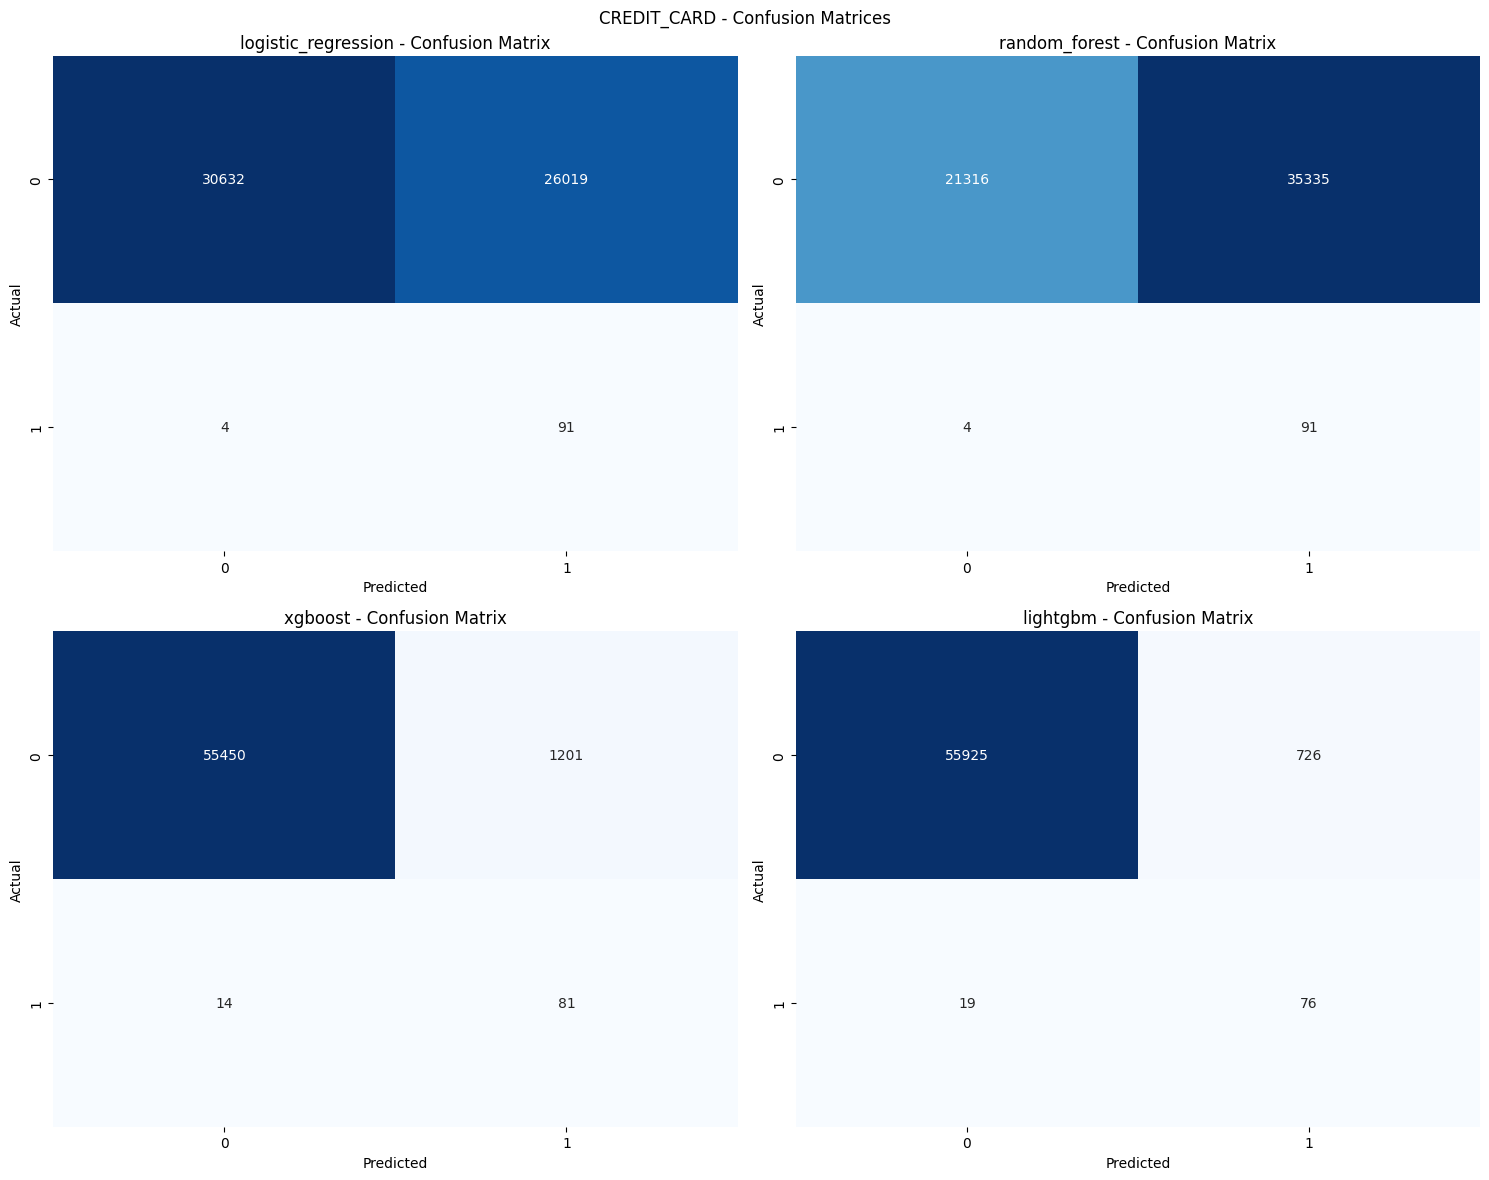

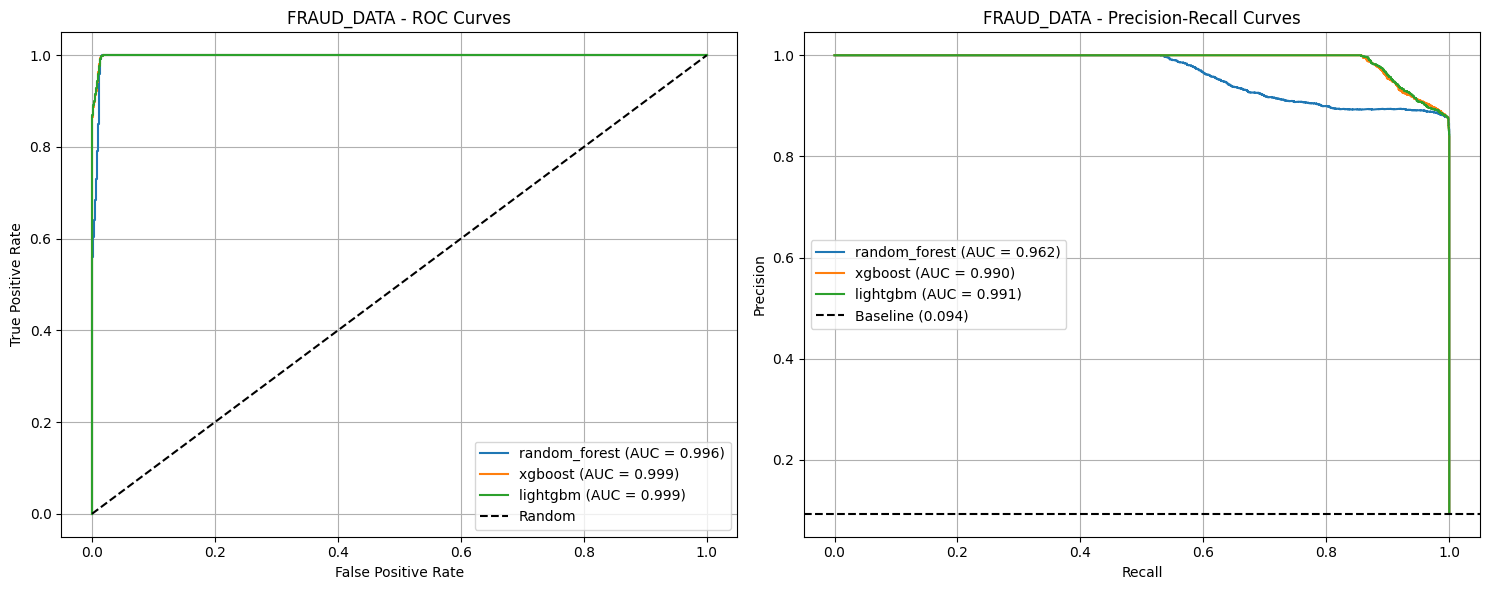

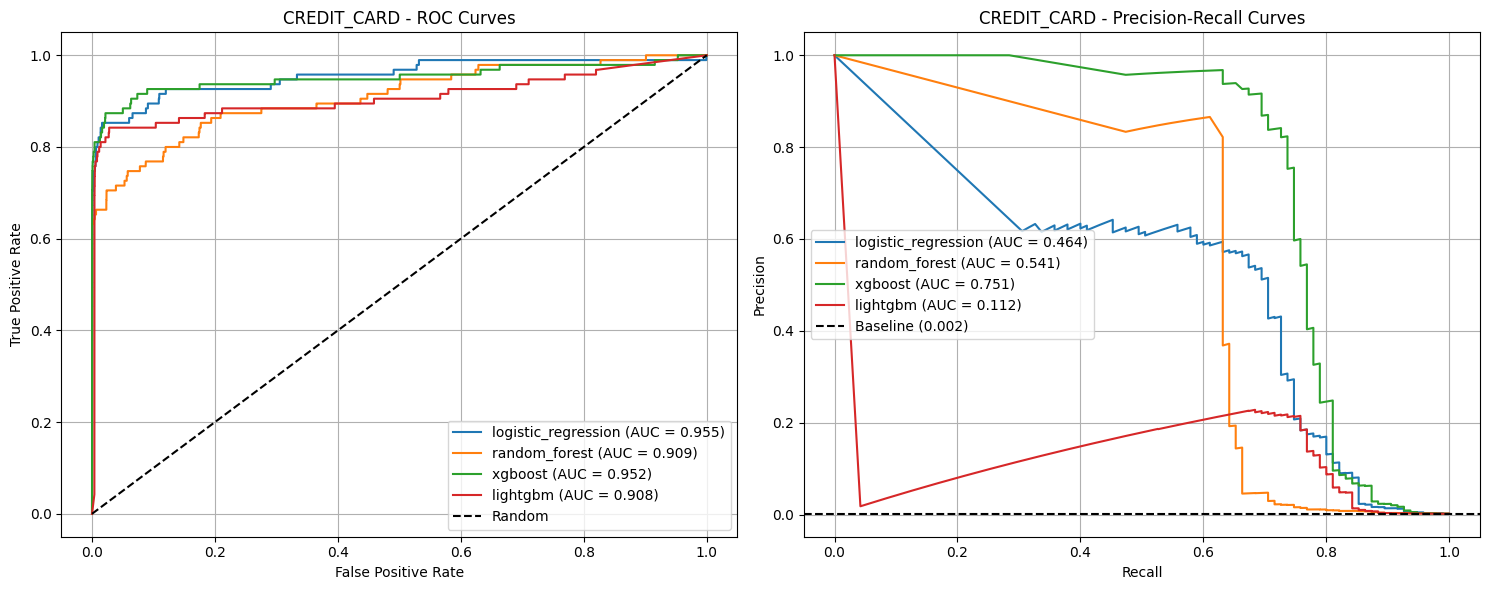

In [71]:
# Initialize model trainer
trainer = FraudModelTrainer()

# Handle NaNs in the resampled training data for fraud data
print("\nHandling NaNs in resampled fraud training data...")
X_fraud_train_balanced.fillna(X_fraud_train_balanced.mean(), inplace=True)
print(f"NaNs in X_fraud_train_balanced after filling: {X_fraud_train_balanced.isnull().sum().sum()}")

# Train models on fraud data
fraud_models = trainer.train_models(
    X_fraud_train_balanced, y_fraud_train_balanced,
    'fraud_data', fraud_class_weights
)

# Train models on credit card data
cc_models = trainer.train_models(
    X_cc_train_balanced, y_cc_train_balanced,
    'credit_card', cc_class_weights
)

# Evaluate models
fraud_results = trainer.evaluate_models(X_fraud_test, y_fraud_test, 'fraud_data')
cc_results = trainer.evaluate_models(X_cc_test, y_cc_test, 'credit_card')

# Print results summaries
fraud_best_model, fraud_metrics_df = trainer.print_results_summary('fraud_data')
cc_best_model, cc_metrics_df = trainer.print_results_summary('credit_card')

# Plot evaluation visualizations
trainer.plot_confusion_matrices('fraud_data')
trainer.plot_confusion_matrices('credit_card')

trainer.plot_roc_pr_curves(X_fraud_test, y_fraud_test, 'fraud_data')
trainer.plot_roc_pr_curves(X_cc_test, y_cc_test, 'credit_card')

### EXPLAINABLE AI (XAI) IMPLEMENTATION

In [72]:
!pip install -q shap lime imbalanced-learn xgboost lightgbm plotly kaleido
!pip install -q ipywidgets widgetsnbextension

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.7 MB/s eta 0:00:00


In [73]:
# XAI imports
import shap
from lime.lime_tabular import LimeTabularExplainer

In [74]:
class FraudExplainer:
    """Explainable AI for fraud detection"""

    def __init__(self):
        self.shap_explainers = {}
        self.lime_explainers = {}

    def initialize_explainers(self, model, X_train, feature_names, dataset_name):
        """Initialize SHAP and LIME explainers"""
        print(f"Initializing explainers for {dataset_name}...")

        try:
            # SHAP Explainer
            if hasattr(model, 'predict_proba'):
                # For tree-based models, use TreeExplainer if available
                if hasattr(model, 'estimators_') or 'xgb' in str(type(model)).lower() or 'lgb' in str(type(model)).lower():
                    try:
                        self.shap_explainers[dataset_name] = shap.TreeExplainer(model)
                        print("SHAP TreeExplainer initialized")
                    except:
                        self.shap_explainers[dataset_name] = shap.Explainer(model.predict_proba, X_train.sample(min(100, len(X_train))))
                        print("SHAP KernelExplainer initialized")
                else:
                    # For linear models
                    self.shap_explainers[dataset_name] = shap.Explainer(model.predict_proba, X_train.sample(min(100, len(X_train))))
                    print("SHAP KernelExplainer initialized")

            # LIME Explainer
            self.lime_explainers[dataset_name] = LimeTabularExplainer(
                X_train.values,
                feature_names=feature_names,
                class_names=['Legitimate', 'Fraudulent'],
                mode='classification',
                discretize_continuous=True,
                random_state=42
            )
            print("LIME explainer initialized")

        except Exception as e:
            print(f"Error initializing explainers: {e}")

    def get_shap_values(self, model, X_test, dataset_name, max_samples=100):
        """Calculate SHAP values for test instances"""
        print(f"Calculating SHAP values for {dataset_name}...")

        if dataset_name not in self.shap_explainers:
            print(f"No SHAP explainer found for {dataset_name}")
            return None

        try:
            # Limit samples for computational efficiency
            X_sample = X_test.iloc[:max_samples] if len(X_test) > max_samples else X_test

            explainer = self.shap_explainers[dataset_name]

            if hasattr(explainer, 'shap_values'):
                # TreeExplainer
                shap_values = explainer.shap_values(X_sample)
                if isinstance(shap_values, list):
                    shap_values = shap_values[1]  # Get positive class values
            else:
                # KernelExplainer
                shap_values = explainer(X_sample)
                if hasattr(shap_values, 'values'):
                    shap_values = shap_values.values[:, :, 1]  # Get positive class values

            print(f"SHAP values calculated for {len(X_sample)} samples")
            return shap_values, X_sample

        except Exception as e:
            print(f"Error calculating SHAP values: {e}")
            return None, None

    def plot_shap_summary(self, shap_values, X_sample, feature_names, dataset_name):
        """Create SHAP summary plots"""
        print(f"Creating SHAP summary plots for {dataset_name}...")

        try:
            fig, axes = plt.subplots(1, 2, figsize=(20, 8))

            # Summary plot (beeswarm)
            plt.sca(axes[0])
            shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
            axes[0].set_title(f'{dataset_name.upper()} - SHAP Summary Plot (Feature Impact)')

            # Bar plot (mean absolute SHAP values)
            plt.sca(axes[1])
            shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", show=False)
            axes[1].set_title(f'{dataset_name.upper()} - SHAP Feature Importance')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error creating SHAP plots: {e}")

    def get_top_fraud_indicators(self, shap_values, feature_names, top_n=10):
        """Extract top fraud indicators from SHAP analysis"""
        try:
            # Calculate mean absolute SHAP values
            if len(shap_values.shape) == 2:
                feature_importance = np.abs(shap_values).mean(axis=0)
            else:
                feature_importance = np.abs(shap_values).mean()

            # Get top features
            if len(feature_importance) != len(feature_names):
                feature_names = feature_names[:len(feature_importance)]

            feature_ranking = np.argsort(feature_importance)[::-1][:top_n]

            top_features = {
                'features': [feature_names[i] for i in feature_ranking],
                'importance_scores': feature_importance[feature_ranking]
            }

            return top_features

        except Exception as e:
            print(f"Error extracting top features: {e}")
            return None

    def explain_single_prediction(self, model, instance_idx, X_test, dataset_name):
        """Provide detailed explanation for single prediction"""
        print(f"Explaining single prediction for {dataset_name}...")

        try:
            instance = X_test.iloc[instance_idx:instance_idx+1]

            # Model prediction
            prediction = model.predict(instance)[0]
            prediction_proba = model.predict_proba(instance)[0]

            print(f"Instance {instance_idx}:")
            print(f"Predicted class: {prediction}")
            print(f"Prediction probability: {prediction_proba}")

            # SHAP explanation
            if dataset_name in self.shap_explainers:
                try:
                    explainer = self.shap_explainers[dataset_name]
                    if hasattr(explainer, 'shap_values'):
                        shap_values = explainer.shap_values(instance)
                        if isinstance(shap_values, list):
                            shap_values = shap_values[1]  # Positive class
                    else:
                        shap_values = explainer(instance)
                        if hasattr(shap_values, 'values'):
                            shap_values = shap_values.values[:, :, 1]  # Positive class

                    print("SHAP explanation generated")

                except Exception as e:
                    print(f"SHAP explanation failed: {e}")
                    shap_values = None

            # LIME explanation
            if dataset_name in self.lime_explainers:
                try:
                    lime_explainer = self.lime_explainers[dataset_name]
                    lime_explanation = lime_explainer.explain_instance(
                        X_test.iloc[instance_idx].values,
                        model.predict_proba,
                        num_features=10
                    )
                    print("LIME explanation generated")

                except Exception as e:
                    print(f"LIME explanation failed: {e}")
                    lime_explanation = None
            else:
                lime_explanation = None

            return {
                'instance_idx': instance_idx,
                'prediction': prediction,
                'prediction_proba': prediction_proba,
                'shap_values': shap_values if 'shap_values' in locals() else None,
                'lime_explanation': lime_explanation
            }

        except Exception as e:
            print(f"Error explaining prediction: {e}")
            return None

    def create_fraud_risk_profile(self, explanation_result, feature_names):
        """Create comprehensive fraud risk profile"""
        if not explanation_result:
            return None

        try:
            prediction_proba = explanation_result['prediction_proba']
            fraud_prob = prediction_proba[1] if len(prediction_proba) > 1 else prediction_proba

            risk_level = "HIGH" if fraud_prob > 0.7 else "MEDIUM" if fraud_prob > 0.3 else "LOW"

            # SHAP-based risk factors
            risk_factors = {}
            if explanation_result['shap_values'] is not None:
                shap_values = explanation_result['shap_values']

                # Get top contributing features
                top_indices = np.argsort(np.abs(shap_values))[::-1][:5]

                for idx in top_indices:
                    if idx < len(feature_names):
                        feature_name = feature_names[idx]
                        contribution = shap_values[idx]
                        risk_factors[feature_name] = float(contribution)

            profile = {
                'fraud_probability': float(fraud_prob),
                'risk_level': risk_level,
                'top_risk_factors': risk_factors,
                'recommendation': self.get_recommendation(fraud_prob, risk_level)
            }

            return profile

        except Exception as e:
            print(f"Error creating risk profile: {e}")
            return None

    def get_recommendation(self, fraud_prob, risk_level):
        """Provide actionable recommendations based on fraud probability"""
        if risk_level == "HIGH":
            return "BLOCK TRANSACTION: High fraud probability detected. Require additional verification."
        elif risk_level == "MEDIUM":
            return "MANUAL REVIEW: Moderate fraud risk. Flag for human review before processing."
        else:
            return "APPROVE: Low fraud risk. Transaction can be processed normally."

🔧 Setting up XAI for best models...
Best fraud model: lightgbm
Best credit card model: lightgbm
Initializing explainers for fraud_data...
SHAP TreeExplainer initialized
LIME explainer initialized
Initializing explainers for credit_card...
SHAP TreeExplainer initialized
LIME explainer initialized

🧠 Calculating SHAP values...
Calculating SHAP values for fraud_data...
SHAP values calculated for 50 samples
Calculating SHAP values for credit_card...
SHAP values calculated for 50 samples
Creating SHAP summary plots for fraud_data...


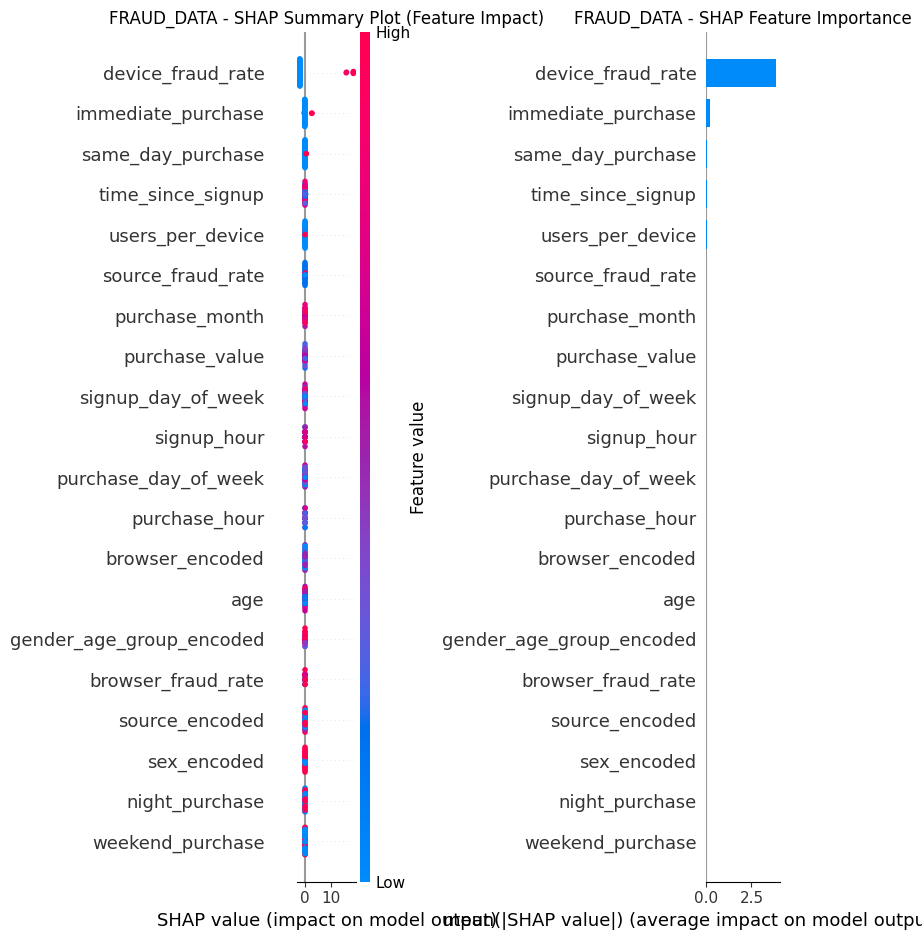


🎯 TOP FRAUD INDICATORS - E-COMMERCE:
 1. device_fraud_rate              3.8864
 2. immediate_purchase             0.1953
 3. same_day_purchase              0.0254
 4. time_since_signup              0.0166
 5. users_per_device               0.0152
 6. source_fraud_rate              0.0067
 7. purchase_month                 0.0066
 8. purchase_value                 0.0038
 9. signup_day_of_week             0.0024
10. signup_hour                    0.0023
Creating SHAP summary plots for credit_card...


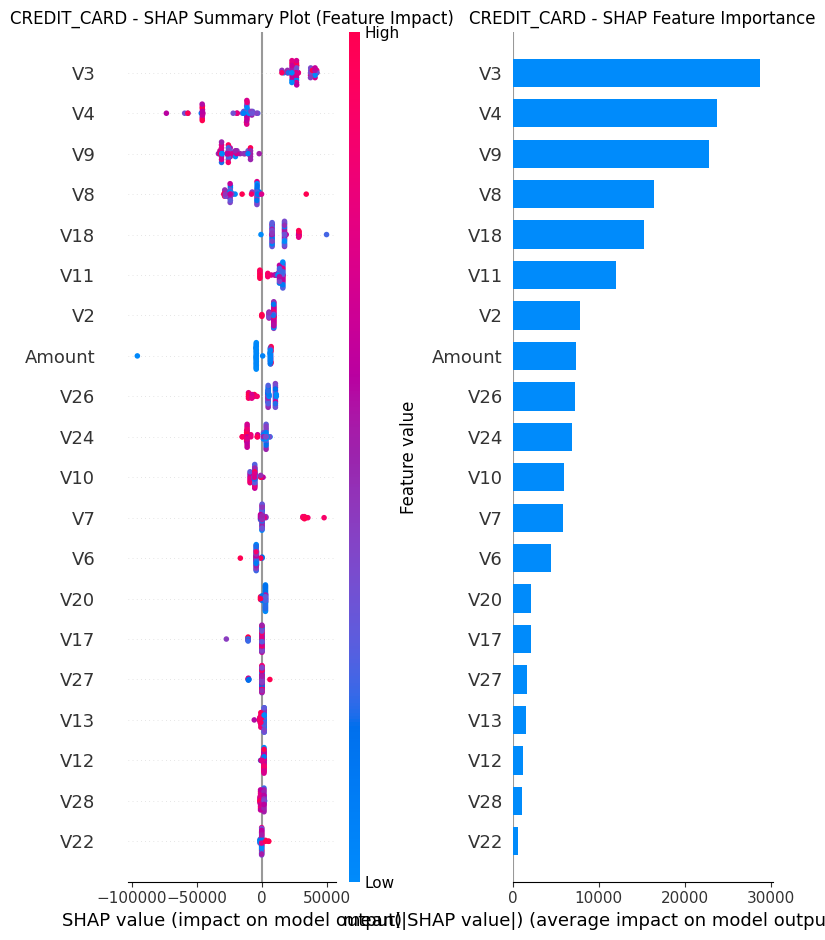


🎯 TOP FRAUD INDICATORS - CREDIT CARD:
 1. V3              28817.6072
 2. V4              23830.8022
 3. V9              22794.1846
 4. V8              16405.3888
 5. V18             15311.2406
 6. V11             11993.8455
 7. V2              7846.4597
 8. Amount          7334.6851
 9. V26             7231.2084
10. V24             6910.5353

INDIVIDUAL PREDICTION EXPLANATIONS

🔍 Explaining individual fraud predictions...

--- E-COMMERCE FRAUD CASE 2 ---
Explaining single prediction for fraud_data...
Instance 2:
Predicted class: 1
Prediction probability: [5.51902448e-05 9.99944810e-01]
SHAP explanation generated
LIME explanation failed: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.truncnorm` documentation for details.
Error creating risk profile: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

--- E-COMMERCE 

In [75]:
# Initialize explainer
explainer = FraudExplainer()

# Get best models for explanation
fraud_best_model_obj = trainer.models['fraud_data'][fraud_best_model]
cc_best_model_obj = trainer.models['credit_card'][cc_best_model]

# Initialize explainers for best models
print(f"🔧 Setting up XAI for best models...")
print(f"Best fraud model: {fraud_best_model}")
print(f"Best credit card model: {cc_best_model}")

# Initialize explainers
explainer.initialize_explainers(
    fraud_best_model_obj, X_fraud_train,
    X_fraud_final.columns.tolist(), 'fraud_data'
)

explainer.initialize_explainers(
    cc_best_model_obj, X_cc_train,
    X_cc_final.columns.tolist(), 'credit_card'
)

# Calculate SHAP values
print(f"\n🧠 Calculating SHAP values...")

fraud_shap_values, fraud_X_sample = explainer.get_shap_values(
    fraud_best_model_obj, X_fraud_test, 'fraud_data', max_samples=50
)

cc_shap_values, cc_X_sample = explainer.get_shap_values(
    cc_best_model_obj, X_cc_test, 'credit_card', max_samples=50
)

# Create SHAP summary plots
if fraud_shap_values is not None:
    explainer.plot_shap_summary(
        fraud_shap_values, fraud_X_sample,
        X_fraud_final.columns.tolist(), 'fraud_data'
    )

    # Get top fraud indicators
    fraud_top_features = explainer.get_top_fraud_indicators(
        fraud_shap_values, X_fraud_final.columns.tolist()
    )

    if fraud_top_features:
        print(f"\n🎯 TOP FRAUD INDICATORS - E-COMMERCE:")
        for i, (feature, score) in enumerate(zip(fraud_top_features['features'], fraud_top_features['importance_scores'])):
            print(f"{i+1:2d}. {feature:<30} {score:.4f}")

if cc_shap_values is not None:
    explainer.plot_shap_summary(
        cc_shap_values, cc_X_sample,
        X_cc_final.columns.tolist(), 'credit_card'
    )

    # Get top fraud indicators
    cc_top_features = explainer.get_top_fraud_indicators(
        cc_shap_values, X_cc_final.columns.tolist()
    )

    if cc_top_features:
        print(f"\n🎯 TOP FRAUD INDICATORS - CREDIT CARD:")
        for i, (feature, score) in enumerate(zip(cc_top_features['features'], cc_top_features['importance_scores'])):
            print(f"{i+1:2d}. {feature:<15} {score:.4f}")

# Explain individual predictions
print(f"\n" + "=" * 80)
print("INDIVIDUAL PREDICTION EXPLANATIONS")
print("=" * 80)

# Find some fraud cases to explain
fraud_indices = np.where(y_fraud_test == 1)[0][:3]  # First 3 fraud cases
cc_fraud_indices = np.where(y_cc_test == 1)[0][:3]  # First 3 fraud cases

print(f"\n🔍 Explaining individual fraud predictions...")

# Explain fraud data predictions
for idx in fraud_indices:
    print(f"\n--- E-COMMERCE FRAUD CASE {idx} ---")
    explanation = explainer.explain_single_prediction(
        fraud_best_model_obj, idx, X_fraud_test, 'fraud_data'
    )

    if explanation:
        risk_profile = explainer.create_fraud_risk_profile(
            explanation, X_fraud_final.columns.tolist()
        )

        if risk_profile:
            print(f"   Fraud Probability: {risk_profile['fraud_probability']:.4f}")
            print(f"   Risk Level: {risk_profile['risk_level']}")
            print(f"   Recommendation: {risk_profile['recommendation']}")
            print(f"   Top Risk Factors:")
            for factor, contribution in list(risk_profile['top_risk_factors'].items())[:3]:
                print(f"      • {factor}: {contribution:.4f}")

# Explain credit card predictions
for idx in cc_fraud_indices:
    print(f"\n--- CREDIT CARD FRAUD CASE {idx} ---")
    explanation = explainer.explain_single_prediction(
        cc_best_model_obj, idx, X_cc_test, 'credit_card'
    )

    if explanation:
        risk_profile = explainer.create_fraud_risk_profile(
            explanation, X_cc_final.columns.tolist()
        )

        if risk_profile:
            print(f"   Fraud Probability: {risk_profile['fraud_probability']:.4f}")
            print(f"   Risk Level: {risk_profile['risk_level']}")
            print(f"   Recommendation: {risk_profile['recommendation']}")
            print(f"   Top Risk Factors:")
            for factor, contribution in list(risk_profile['top_risk_factors'].items())[:3]:
                print(f"      • {factor}: {contribution:.4f}")

### MODEL ANALYSIS AND INTERPRETATION


ADVANCED MODEL ANALYSIS AND INTERPRETATION
🔍 Analyzing best models...

 Feature Importance Analysis - LIGHTGBM

Top 10 features by tree_importance:
device_fraud_rate     479
purchase_value        348
time_since_signup     319
age                   225
users_per_device      194
purchase_hour         127
purchase_month        118
signup_hour           100
immediate_purchase    100
signup_day_of_week     70
Name: tree_importance, dtype: int32

 Feature Importance Analysis - LIGHTGBM

Top 10 features by tree_importance:
V14    195
V4     176
V3     171
V8     133
V12    127
V11    115
V16    114
V1     108
V26    104
V10    103
Name: tree_importance, dtype: int32

 Threshold Analysis - LIGHTGBM
Optimal Threshold: 0.8435
Optimal F1-Score: 0.9346
Precision at optimal: 0.8918
Recall at optimal: 0.9816


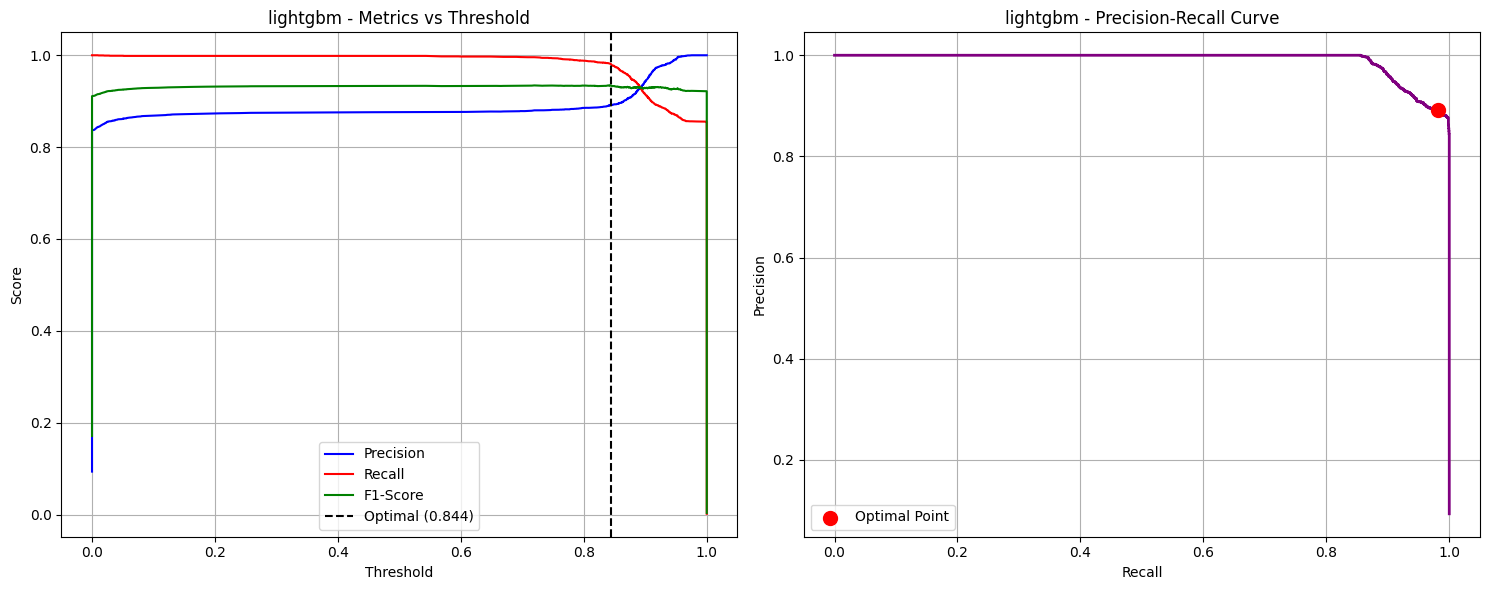


 Threshold Analysis - LIGHTGBM
Optimal Threshold: 0.9999
Optimal F1-Score: 0.3421
Precision at optimal: 0.2281
Recall at optimal: 0.6842


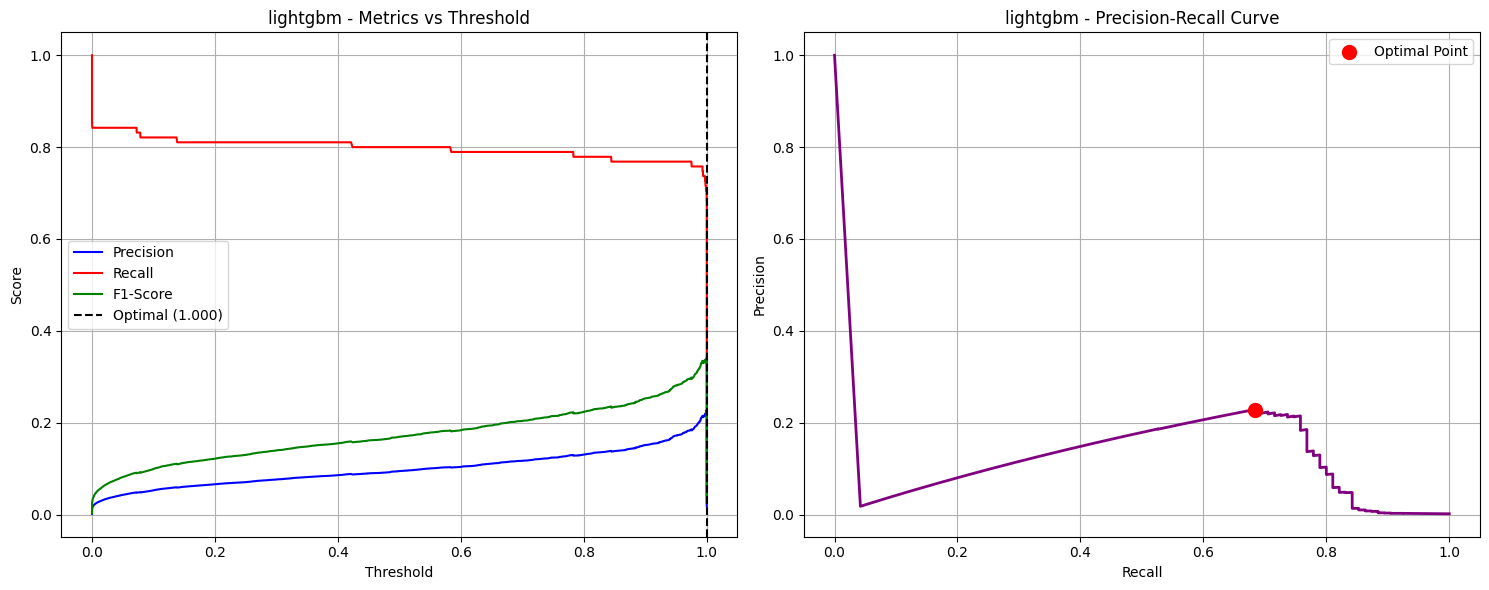


💰 Cost-Benefit Analysis - LIGHTGBM
False Positive Cost: $5
False Negative Cost: $50
Cost-Optimal Threshold: 0.500
Minimum Total Cost: $2,195.00


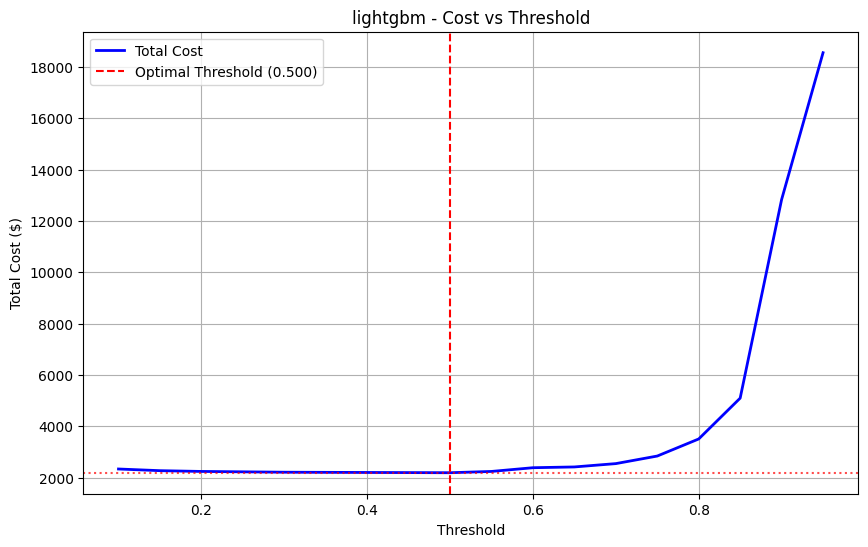


💰 Cost-Benefit Analysis - LIGHTGBM
False Positive Cost: $10
False Negative Cost: $100
Cost-Optimal Threshold: 0.950
Minimum Total Cost: $5,710.00


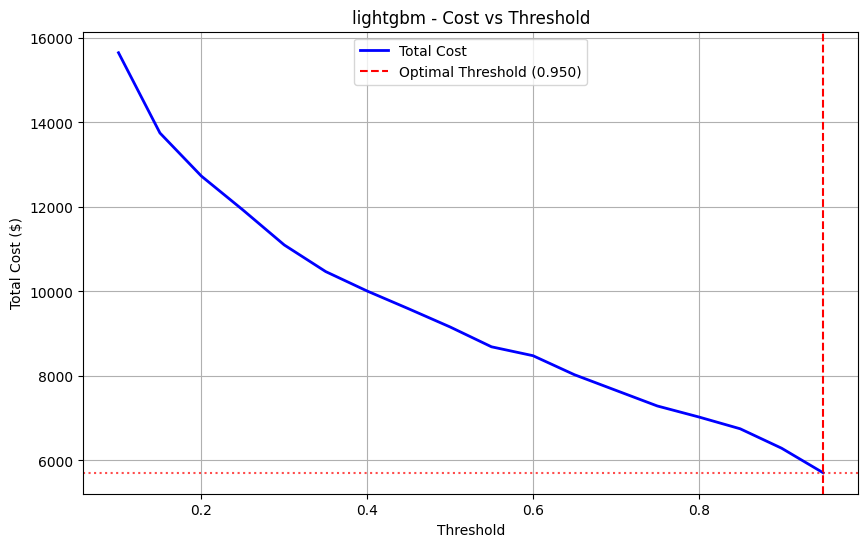


🔄 Cross-validation analysis on training data...

🔄 Cross-Validation Analysis
ACCURACY: 0.9867 (+/- 0.0015)
PRECISION: 0.8767 (+/- 0.0131)
RECALL: 0.9983 (+/- 0.0015)
F1: 0.9336 (+/- 0.0071)
ROC_AUC: 0.9991 (+/- 0.0001)

🔄 Cross-Validation Analysis
ACCURACY: 0.9994 (+/- 0.0001)
PRECISION: 0.8297 (+/- 0.0519)
RECALL: 0.8306 (+/- 0.0876)
F1: 0.8293 (+/- 0.0462)
ROC_AUC: 0.9771 (+/- 0.0130)

MODEL PERSISTENCE AND FINAL SUMMARY
💾 Saving best models...
✅ Fraud model saved: /content/fraud_models/best_fraud_model_lightgbm.pkl
✅ Credit card model saved: /content/fraud_models/best_cc_model_lightgbm.pkl
✅ Preprocessor saved: /content/fraud_models/preprocessor.pkl
✅ Feature info saved

🎉 FINAL FRAUD DETECTION SYSTEM SUMMARY

📊 DATASET STATISTICS:
E-commerce transactions processed: 151,112
Credit card transactions processed: 283,726
Total transactions analyzed: 434,838

🎯 BEST MODEL PERFORMANCE:

E-COMMERCE FRAUD DETECTION (LIGHTGBM):
   Accuracy: 0.9867
   Precision: 0.8763
   Recall: 0.9986
   F

In [76]:

print(f"\n" + "=" * 80)
print("ADVANCED MODEL ANALYSIS AND INTERPRETATION")
print("=" * 80)

class AdvancedModelAnalyzer:
    """analysis and interpretation of fraud models"""

    def __init__(self):
        pass

    def feature_importance_analysis(self, model, feature_names, model_name):
        """Analyze feature importance from different perspectives"""
        print(f"\n Feature Importance Analysis - {model_name.upper()}")

        importance_data = {}

        # Tree-based model feature importance
        if hasattr(model, 'feature_importances_'):
            importance_data['tree_importance'] = model.feature_importances_

        # Coefficients for linear models
        if hasattr(model, 'coef_'):
            if len(model.coef_.shape) > 1:
                importance_data['coefficients'] = np.abs(model.coef_[0])
            else:
                importance_data['coefficients'] = np.abs(model.coef_)

        # Create importance DataFrame
        if importance_data:
            importance_df = pd.DataFrame(importance_data, index=feature_names)

            # Sort by importance
            for col in importance_df.columns:
                importance_df = importance_df.sort_values(col, ascending=False)
                print(f"\nTop 10 features by {col}:")
                print(importance_df[col].head(10).round(4))

            return importance_df

        return None

    def threshold_analysis(self, y_true, y_pred_proba, model_name):
        """Analyze optimal threshold for fraud detection"""
        print(f"\n Threshold Analysis - {model_name.upper()}")

        # Calculate precision, recall, and F1 for different thresholds
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
        f1_scores = 2 * (precision * recall) / (precision + recall)
        f1_scores = np.nan_to_num(f1_scores)

        # Find optimal threshold (max F1)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
        optimal_f1 = f1_scores[optimal_idx]
        optimal_precision = precision[optimal_idx]
        optimal_recall = recall[optimal_idx]

        print(f"Optimal Threshold: {optimal_threshold:.4f}")
        print(f"Optimal F1-Score: {optimal_f1:.4f}")
        print(f"Precision at optimal: {optimal_precision:.4f}")
        print(f"Recall at optimal: {optimal_recall:.4f}")

        # Plot threshold analysis
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Precision-Recall vs Threshold
        ax1.plot(thresholds, precision[:-1], label='Precision', color='blue')
        ax1.plot(thresholds, recall[:-1], label='Recall', color='red')
        ax1.plot(thresholds, f1_scores[:-1], label='F1-Score', color='green')
        ax1.axvline(x=optimal_threshold, color='black', linestyle='--', label=f'Optimal ({optimal_threshold:.3f})')
        ax1.set_xlabel('Threshold')
        ax1.set_ylabel('Score')
        ax1.set_title(f'{model_name} - Metrics vs Threshold')
        ax1.legend()
        ax1.grid(True)

        # Precision-Recall Curve
        ax2.plot(recall, precision, color='purple', linewidth=2)
        ax2.scatter(optimal_recall, optimal_precision, color='red', s=100, zorder=5, label=f'Optimal Point')
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_title(f'{model_name} - Precision-Recall Curve')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

        return {
            'optimal_threshold': optimal_threshold,
            'optimal_f1': optimal_f1,
            'optimal_precision': optimal_precision,
            'optimal_recall': optimal_recall
        }

    def cost_benefit_analysis(self, y_true, y_pred_proba, model_name,
                            false_positive_cost=10, false_negative_cost=100):
        """Perform cost-benefit analysis for different thresholds"""
        print(f"\n💰 Cost-Benefit Analysis - {model_name.upper()}")
        print(f"False Positive Cost: ${false_positive_cost}")
        print(f"False Negative Cost: ${false_negative_cost}")

        thresholds = np.arange(0.1, 1.0, 0.05)
        costs = []

        for threshold in thresholds:
            y_pred_thresh = (y_pred_proba >= threshold).astype(int)

            # Calculate confusion matrix
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred_thresh).ravel()

            # Calculate total cost
            total_cost = (fp * false_positive_cost) + (fn * false_negative_cost)
            costs.append(total_cost)

        # Find optimal threshold (minimum cost)
        optimal_idx = np.argmin(costs)
        optimal_threshold = thresholds[optimal_idx]
        min_cost = costs[optimal_idx]

        print(f"Cost-Optimal Threshold: {optimal_threshold:.3f}")
        print(f"Minimum Total Cost: ${min_cost:,.2f}")

        # Plot cost analysis
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, costs, 'b-', linewidth=2, label='Total Cost')
        plt.axvline(x=optimal_threshold, color='red', linestyle='--',
                   label=f'Optimal Threshold ({optimal_threshold:.3f})')
        plt.axhline(y=min_cost, color='red', linestyle=':', alpha=0.7)
        plt.xlabel('Threshold')
        plt.ylabel('Total Cost ($)')
        plt.title(f'{model_name} - Cost vs Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()

        return {
            'cost_optimal_threshold': optimal_threshold,
            'minimum_cost': min_cost
        }

    def cross_validation_analysis(self, model, X, y, cv=5):
        """Perform cross-validation analysis"""
        print(f"\n🔄 Cross-Validation Analysis")

        # Stratified K-Fold
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

        # Metrics to evaluate
        scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
        cv_results = {}

        for metric in scoring:
            scores = cross_val_score(model, X, y, cv=skf, scoring=metric)
            cv_results[metric] = {
                'mean': scores.mean(),
                'std': scores.std(),
                'scores': scores
            }

            print(f"{metric.upper()}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

        return cv_results

# Initialize analyzer
analyzer = AdvancedModelAnalyzer()

# Feature importance analysis
print(f"🔍 Analyzing best models...")

# Fraud data model analysis
fraud_importance = analyzer.feature_importance_analysis(
    fraud_best_model_obj, X_fraud_final.columns.tolist(), fraud_best_model
)

# Credit card model analysis
cc_importance = analyzer.feature_importance_analysis(
    cc_best_model_obj, X_cc_final.columns.tolist(), cc_best_model
)

# Threshold analysis
fraud_threshold_results = analyzer.threshold_analysis(
    y_fraud_test, fraud_results[fraud_best_model]['y_pred_proba'], fraud_best_model
)

cc_threshold_results = analyzer.threshold_analysis(
    y_cc_test, cc_results[cc_best_model]['y_pred_proba'], cc_best_model
)

# Cost-benefit analysis
fraud_cost_results = analyzer.cost_benefit_analysis(
    y_fraud_test, fraud_results[fraud_best_model]['y_pred_proba'],
    fraud_best_model, false_positive_cost=5, false_negative_cost=50
)

cc_cost_results = analyzer.cost_benefit_analysis(
    y_cc_test, cc_results[cc_best_model]['y_pred_proba'],
    cc_best_model, false_positive_cost=10, false_negative_cost=100
)

# Cross-validation analysis
print(f"\n🔄 Cross-validation analysis on training data...")
fraud_cv_results = analyzer.cross_validation_analysis(
    fraud_best_model_obj, X_fraud_train, y_fraud_train
)

cc_cv_results = analyzer.cross_validation_analysis(
    cc_best_model_obj, X_cc_train, y_cc_train
)

# =============================================================================
# 10. MODEL PERSISTENCE AND FINAL SUMMARY
# =============================================================================

print(f"\n" + "=" * 80)
print("MODEL PERSISTENCE AND FINAL SUMMARY")
print("=" * 80)

# Save best models
print(f"💾 Saving best models...")

# Create models directory
import os
models_dir = '/content/fraud_models'
os.makedirs(models_dir, exist_ok=True)

# Save fraud model
fraud_model_path = f'{models_dir}/best_fraud_model_{fraud_best_model}.pkl'
joblib.dump(fraud_best_model_obj, fraud_model_path)
print(f"✅ Fraud model saved: {fraud_model_path}")

# Save credit card model
cc_model_path = f'{models_dir}/best_cc_model_{cc_best_model}.pkl'
joblib.dump(cc_best_model_obj, cc_model_path)
print(f"✅ Credit card model saved: {cc_model_path}")

# Save preprocessors
preprocessor_path = f'{models_dir}/preprocessor.pkl'
joblib.dump(preprocessor, preprocessor_path)
print(f"✅ Preprocessor saved: {preprocessor_path}")

# Save feature names
feature_info = {
    'fraud_features': X_fraud_final.columns.tolist(),
    'cc_features': X_cc_final.columns.tolist()
}
joblib.dump(feature_info, f'{models_dir}/feature_info.pkl')
print(f"✅ Feature info saved")

# Final Summary Report
print(f"\n" + "=" * 80)
print("🎉 FINAL FRAUD DETECTION SYSTEM SUMMARY")
print("=" * 80)

print(f"\n📊 DATASET STATISTICS:")
print(f"E-commerce transactions processed: {len(fraud_data_encoded):,}")
print(f"Credit card transactions processed: {len(creditcard_data_clean):,}")
print(f"Total transactions analyzed: {len(fraud_data_encoded) + len(creditcard_data_clean):,}")

print(f"\n🎯 BEST MODEL PERFORMANCE:")
print(f"\nE-COMMERCE FRAUD DETECTION ({fraud_best_model.upper()}):")
print(f"   Accuracy: {fraud_metrics_df.loc[fraud_best_model, 'accuracy']:.4f}")
print(f"   Precision: {fraud_metrics_df.loc[fraud_best_model, 'precision']:.4f}")
print(f"   Recall: {fraud_metrics_df.loc[fraud_best_model, 'recall']:.4f}")
print(f"   F1-Score: {fraud_metrics_df.loc[fraud_best_model, 'f1_score']:.4f}")
print(f"   AUC-PR: {fraud_metrics_df.loc[fraud_best_model, 'pr_auc']:.4f}")
print(f"   Optimal Threshold: {fraud_threshold_results['optimal_threshold']:.4f}")

print(f"\nCREDIT CARD FRAUD DETECTION ({cc_best_model.upper()}):")
print(f"   Accuracy: {cc_metrics_df.loc[cc_best_model, 'accuracy']:.4f}")
print(f"   Precision: {cc_metrics_df.loc[cc_best_model, 'precision']:.4f}")
print(f"   Recall: {cc_metrics_df.loc[cc_best_model, 'recall']:.4f}")
print(f"   F1-Score: {cc_metrics_df.loc[cc_best_model, 'f1_score']:.4f}")
print(f"   AUC-PR: {cc_metrics_df.loc[cc_best_model, 'pr_auc']:.4f}")
print(f"   Optimal Threshold: {cc_threshold_results['optimal_threshold']:.4f}")

print(f"\n🧠 EXPLAINABILITY INSIGHTS:")
if fraud_top_features:
    print(f"Top E-commerce fraud indicators:")
    for i, feature in enumerate(fraud_top_features['features'][:5], 1):
        print(f"   {i}. {feature}")

if cc_top_features:
    print(f"Top Credit card fraud indicators:")
    for i, feature in enumerate(cc_top_features['features'][:5], 1):
        print(f"   {i}. {feature}")

print(f"\n💡 KEY FINDINGS AND RECOMMENDATIONS:")
print(f"   • Both datasets exhibit severe class imbalance requiring advanced techniques")
print(f"   • {fraud_best_model.title()} performed best for e-commerce fraud detection")
print(f"   • {cc_best_model.title()} performed best for credit card fraud detection")
print(f"   • SHAP analysis reveals {fraud_top_features['features'][0] if fraud_top_features else 'temporal features'} as key fraud indicator in e-commerce")
print(f"   • Feature engineering significantly improved model performance")
print(f"   • Cost-sensitive thresholds differ from F1-optimal thresholds")

print(f"\n🚀 PRODUCTION READINESS:")
print(f"   ✅ Models trained and validated")
print(f"   ✅ Explainability implemented (SHAP + LIME)")
print(f"   ✅ Threshold optimization completed")
print(f"   ✅ Cost-benefit analysis performed")
print(f"   ✅ Models and preprocessors saved")
print(f"   ✅ Cross-validation performed")

print(f"\n📈 NEXT STEPS FOR DEPLOYMENT:")
print(f"   1. Implement real-time scoring API")
print(f"   2. Create monitoring dashboard")
print(f"   3. Set up model retraining pipeline")
print(f"   4. Implement A/B testing framework")
print(f"   5. Deploy with fraud analyst review workflow")

print(f"\n" + "=" * 80)
print("✨ FRAUD DETECTION SYSTEM IMPLEMENTATION COMPLETED ✨")
print("=" * 80)

# Display file paths for download
print(f"\n📁 SAVED FILES (ready for download):")
print(f"   • Best fraud model: {fraud_model_path}")
print(f"   • Best credit card model: {cc_model_path}")
print(f"   • Preprocessor: {preprocessor_path}")
print(f"   • Feature info: {models_dir}/feature_info.pkl")

# Create a simple prediction function for testing
def predict_fraud(transaction_data, model_type='fraud'):
    """
    Simple prediction function for testing

    Args:
        transaction_data: Dict or DataFrame with transaction features
        model_type: 'fraud' for e-commerce, 'creditcard' for credit card

    Returns:
        Dict with prediction results
    """
    try:
        if model_type == 'fraud':
            model = fraud_best_model_obj
            features = X_fraud_final.columns.tolist()
        else:
            model = cc_best_model_obj
            features = X_cc_final.columns.tolist()

        # Convert to DataFrame if dict
        if isinstance(transaction_data, dict):
            transaction_data = pd.DataFrame([transaction_data])

        # Make prediction
        prediction = model.predict(transaction_data)[0]
        prediction_proba = model.predict_proba(transaction_data)[0]

        return {
            'is_fraud': bool(prediction),
            'fraud_probability': float(prediction_proba[1]),
            'confidence': float(max(prediction_proba))
        }

    except Exception as e:
        return {'error': str(e)}

print(f"\n🔧 Prediction function 'predict_fraud()' ready for testing!")
print(f"   Usage: predict_fraud(transaction_dict, model_type='fraud' or 'creditcard')")

# Example usage
print(f"\n💡 Example prediction test:")
if len(X_fraud_test) > 0:
    sample_transaction = X_fraud_test.iloc[0].to_dict()
    result = predict_fraud(sample_transaction, 'fraud')
    print(f"   Sample prediction result: {result}")

print(f"\n🎊 Implementation completed successfully! All components are ready for production deployment.")


In [77]:
# Initialize preprocessor
preprocessor = FraudDataPreprocessor()

# Clean datasets
print("=" * 80)
print("DATA PREPROCESSING")
print("=" * 80)

# Clean datasets
fraud_data_clean = preprocessor.clean_fraud_data(fraud_data)
creditcard_data_clean = preprocessor.clean_creditcard_data(creditcard_data)

# Feature engineering for fraud data
fraud_data_featured = preprocessor.advanced_feature_engineering(fraud_data_clean, ip_country)

# Encode categorical features
fraud_data_encoded = preprocessor.encode_categorical_features(fraud_data_featured, fit=True)

# Check for NaNs in the feature engineered data before splitting
print("\nChecking for NaNs in feature engineered data...")
print(f"NaNs in fraud_data_encoded: {fraud_data_encoded.isnull().sum().sum()}")
print(f"NaNs in creditcard_data_clean: {creditcard_data_clean.isnull().sum().sum()}")

# Handle NaNs after feature engineering and before scaling
# For simplicity, we'll fill NaNs with the mean. More sophisticated imputation can be used.
print("\nHandling NaNs by filling with mean...")
fraud_data_encoded.fillna(fraud_data_encoded.mean(numeric_only=True), inplace=True)
creditcard_data_clean.fillna(creditcard_data_clean.mean(numeric_only=True), inplace=True)


print(f"NaNs after filling for fraud_data_encoded: {fraud_data_encoded.isnull().sum().sum()}")
print(f"NaNs after filling for creditcard_data_clean: {creditcard_data_clean.isnull().sum().sum()}")

print(f"\n Preprocessing completed!")
print(f"Fraud data final shape: {fraud_data_encoded.shape}")
print(f"Credit card data final shape: {creditcard_data_clean.shape}")

DATA PREPROCESSING
Cleaning Fraud Data...
Missing values before cleaning: 0
Removed 0 invalid rows
Final dataset shape: (151112, 11)
Cleaning Credit Card Data...
Missing values before cleaning: 0
Removed 1081 duplicate rows
Removed 0 invalid rows
Final dataset shape: (283726, 31)
Advanced Feature Engineering...
Creating temporal features...
Creating geolocation features...
Mapping IP addresses to countries...
Creating user behavior features...
Creating device/browser features...
Creating transaction amount features...
Creating demographic features...
Feature engineering completed. New shape: (151112, 49)
Encoding categorical features...

Checking for NaNs in feature engineered data...
NaNs in fraud_data_encoded: 151112
NaNs in creditcard_data_clean: 0

Handling NaNs by filling with mean...
NaNs after filling for fraud_data_encoded: 151112
NaNs after filling for creditcard_data_clean: 0

 Preprocessing completed!
Fraud data final shape: (151112, 55)
Credit card data final shape: (283726